<center>
 <h1> INF395 - Introducción a las Redes Neuronales Artificiales</h1>
    <h2> Tarea 1</h2>
</center>
<b>Integrantes:</b>
* Camilo Saldías González - 201223512-K - camilo.saldias.12@sansano.usm.cl
* Felipe Vásquez Astudillo - 201473504-9 - felipe.vasquez.14@sansano.usm.cl

# Tabla de contenido
* [1.-Predicción del precio de una Casa](#p1)
* [2.-*Deep Networks*](#p2)
* [3.-Convolutional Neural Network (CNN) en CIFAR](#p3)
* [4.-Aplicación de una red neuronal en Localización](#p4)

<div id='p1' />
## 1. Predicción del precio de una Casa

In [1]:
#Importamos todo lo que utilizaremos en la pregunta
import pandas as pd
from sklearn.cross_validation import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.ticker import NullFormatter
from timeit import default_timer as timer
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1, l2

/Users/camilo/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/camilo/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**Parte a)**

Primero, construímos el dataframe a partir del dataset de Boston Housing. El dataset de Boston Housing consiste de 506 entradas correspondientes a distintos suburbios de Boston, con indicadores tales como: índice de criminalidad per cápita, impuestos a la propiedad, proporción de contaminantes en el aire, etc. En este caso, la conversión de CHAS a un vector binario de 2 componentes permite que la red aprenda de mejor forma las dos características posibles para esta variable, en este caso, la presencia o no de un río cercano. Esto nos permite obtener un conjunto más variado de predicciones que utilizando una única etiqueta.

In [2]:
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df = pd.get_dummies(df,columns=["CHAS"]) #to categorical
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
CRIM       506 non-null float64
ZN         506 non-null int64
INDUS      506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null int64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
CHAS_0     506 non-null uint8
CHAS_1     506 non-null uint8
dtypes: float64(9), int64(4), uint8(2)
memory usage: 52.5 KB


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CHAS_0,CHAS_1
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.347826,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.083004,356.674032,12.653063,22.532806,0.930830,0.069170
std,8.601545,23.310593,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.280574,91.294864,7.141062,9.197104,0.253994,0.253994
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.000000,0.320000,1.730000,5.000000,0.000000,0.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.000000,375.377500,6.950000,17.025000,1.000000,0.000000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.000000,391.440000,11.360000,21.200000,1.000000,0.000000
75%,3.677082,12.000000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.000000,396.225000,16.955000,25.000000,1.000000,0.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.000000,1.000000


Dado que es una buena práctica, normalizamos los datos de los sets de entrenamiento y de prueba.

In [0]:
#Normalizamos los datos para los sets de entrenamiento y de prueba

scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = df_train.pop('MEDV').values.reshape([-1,1])

In [0]:
scaler = StandardScaler().fit(df_test)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test = df_test.pop('MEDV').values.reshape([-1,1])

**Parte b)**

A continuación, entrenamos una red *feedforward* de 3 capas, con 200 unidades ocultas y función de activación sigmoidal, utilizando SGD con un learning rate de 0.01 y 300 epochs de entrenamiento.

In [0]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mean_squared_error')
hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))

Una vez entrenada, obtenemos el gráfico del error cuadrático (MSE) para los sets de entrenamiento y de prueba, como una función del número de epochs.

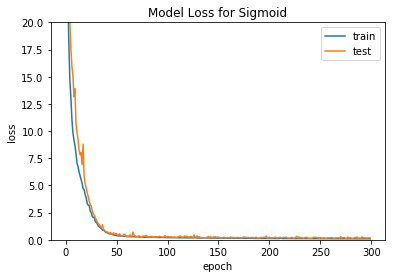

In [6]:
plt.plot(range(0, 300), hist.history["loss"])
plt.plot(range(0, 300), hist.history["val_loss"])
plt.legend(['train', 'test'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss for Sigmoid')
plt.ylim(ymax=20, ymin=0)

plt.show()

Observamos que la red logra converger en menos de 50 epochs, observándose unas pequeñas variaciones en la curva de error del set de pruebas cercana a los 25 epochs. A partir de los 100 epochs, sin embargo, no se logra apreciar variaciones significativas en las curvas de error de ambos sets.

**Parte c)**

Repetimos el mismo procedimiento del punto anterior, pero esta vez utilizando una red con función de activación ReLU.

In [0]:
model2 = Sequential()
model2.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
model2.add(Activation('relu'))
model2.add(Dense(1, kernel_initializer='uniform'))
model2.add(Activation('linear'))
sgd2 = SGD(lr=0.01)
model2.compile(optimizer=sgd2,loss='mean_squared_error')
hist2 = model2.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))

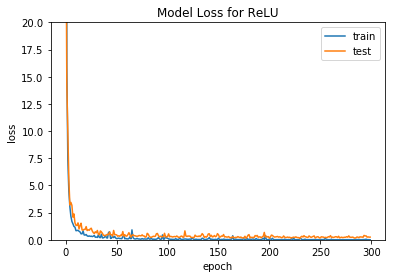

In [8]:
plt.plot(range(0, 300), hist2.history["loss"])
plt.plot(range(0, 300), hist2.history["val_loss"])
plt.legend(['train', 'test'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss for ReLU')
plt.ylim(ymax=20, ymin=0)

plt.show()

Comparando con la red entrenada en el punto b), se puede obsevar que la red entrenada con función de activación ReLU converge de forma mucho más rápida, llegando a un estado de convergencia en menos de la mitad del número de epochs que le tomó a la red c/función sigmoidal llegar a un estado similar. Se pueden observar, además, que la curva del error del set de pruebas tiene algunas variaciones muy pequeñas visibles hasta más allá de los 100 epochs, aunque esto no afecta significativamente la comparativa planteada anteriormente.

**Parte d)**

A continuación procedemos a variar el learning rate de los modelos presentados en b) y c), para estudiar el efecto que tiene sobre la convergencia de la red. Para observar de mejor forma el efecto del valor del learning rate sobre la red, utilizamos una escala logarítmica para variar los valores del learning rate, desde $10^{-5}$ hasta $10^{-1}$.

In [9]:
n_lr = 5
lear_rate = np.logspace(start=-5, stop=-1, num=n_lr, base=10)
sigmoid_loss = {}
sigmoid_val_loss = {}
for lr in lear_rate:
  print("lr="+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=lr) #Con lr más de 0.025, hell breaks loose.
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  sigmoid_loss[lr] = hist.history["loss"]
  sigmoid_val_loss[lr] = hist.history["val_loss"]

lr=1e-05
lr=0.0001
lr=0.001
lr=0.01
lr=0.1


A partir de ahora, utilizaremos una función auxiliar para visualizar los errores de los sets de entrenamiento y de prueba de cada red que implementemos.

In [0]:
def display_stats(title, prefix, ymax, model_loss, model_val_loss):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

  legend = []
  for lr, loss in list(model_loss.items()):
    ax1.plot(range(0, 300), loss)
    legend.append(prefix+str(lr))

  ax1.set_ylim(ymax=ymax, ymin=0)
  ax1.set_title("Train Loss for "+title)
  ax1.legend(legend, loc='upper right')

  legend = []
  for lr, loss in list(model_val_loss.items()):
    ax2.plot(range(0, 300), loss)
    legend.append(prefix+str(lr))

  ax2.set_ylim(ymax=ymax, ymin=0)
  ax2.set_title("Test Loss for "+title)
  ax2.legend(legend, loc='upper right')

  plt.show()

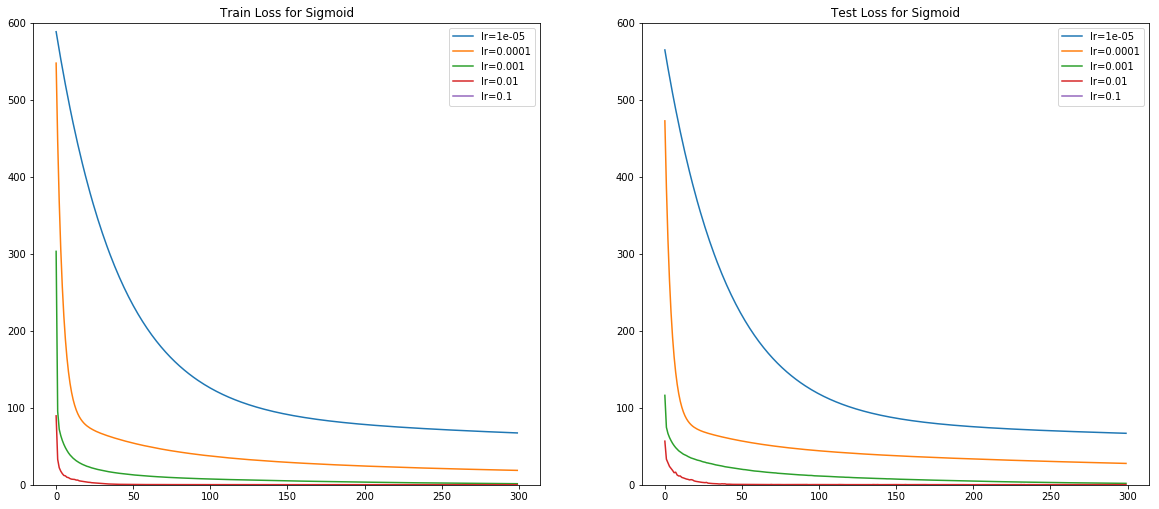

In [11]:
display_stats("Sigmoid", "lr=", 600, sigmoid_loss, sigmoid_val_loss)

Podemos sacar algunas conclusiones interesantes a partir de estos gráficos. Primero, que mientras más grande sea el valor del learning rate, más rápido convergerá la red. Esto, sin emgargo, tiene un límite, como podemos concluir de la ausencia de una curva de error para un learning rate de 0.01. Esto significa que valores para el learning rate cercanos a 0.1 harán que la red diverja y no logre realizar predicciones sobre el modelo planteado. Además, mientras menor sea el valor del learning rate, mayor el número de epochs requeridos para alcanzar convergencia, como se puede observar comparando las curvas de error: mientras que con un learning rate de 0.001 se logra llegar a valores cercanos a cero aproximadamente a los 300 epochs, con un learning rate de 0.01 sólo hacen falta menos de 50 epochs.

Repetimos el experimento, ahora con la red del punto c).

In [12]:
n_lr = 5
lear_rate = np.logspace(start=-5, stop=-1, num=n_lr, base=10)
relu_loss = {}
relu_val_loss = {}
for lr in lear_rate:
  print("lr="+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=lr) #Con lr más de 0.025, hell breaks loose.
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  relu_loss[lr] = hist.history["loss"]
  relu_val_loss[lr] = hist.history["val_loss"]

lr=1e-05
lr=0.0001
lr=0.001
lr=0.01
lr=0.1


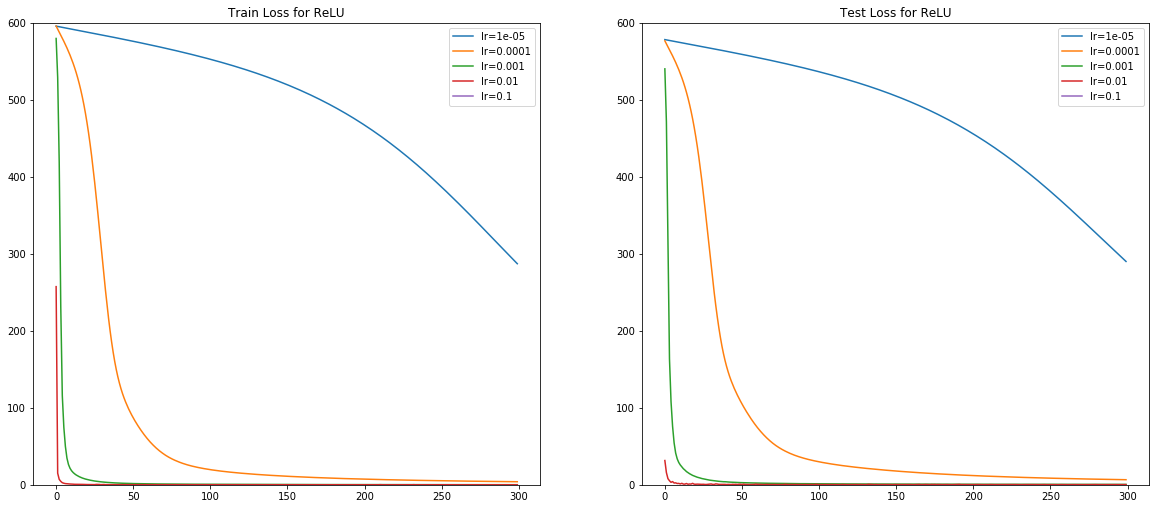

In [13]:
display_stats("ReLU", "lr=", 600, relu_loss, relu_val_loss)

Para el caso de ReLU podemos obtener las mismas conclusiones que obtuvimos para el caso de la red con función sigmoidal, sólo que en este caso la diferencia entre las curvas de errores de distintos learning rates es más notoria que en el caso de la función sigmoidal.

**Parte e)**

Ahora procedemos a entrenar los modelos presentados en b) y c) utiizando *progressive decay*, para estudiar el efecto que tiene sobre la convergencia de la red. Para observar de mejor forma el efecto del valor del decay sobre la red, utilizamos una escala logarítmica para variar los valores del decay, desde $10^{-7}$ hasta $10^{-1}$, manteniendo un valor constante de 0.01 para el learning rate para ambos modelos.

In [14]:
n_dr = 7
decay_rate = np.logspace(start=-7, stop=-1, num=n_dr, base=10)
sigmoid_loss = {}
sigmoid_val_loss = {}
for dr in decay_rate:
  print("dr="+str(dr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=0.01, decay=dr)
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  sigmoid_loss[dr] = hist.history["loss"]
  sigmoid_val_loss[dr] = hist.history["val_loss"]

dr=1e-07
dr=1e-06
dr=1e-05
dr=0.0001
dr=0.001
dr=0.01
dr=0.1


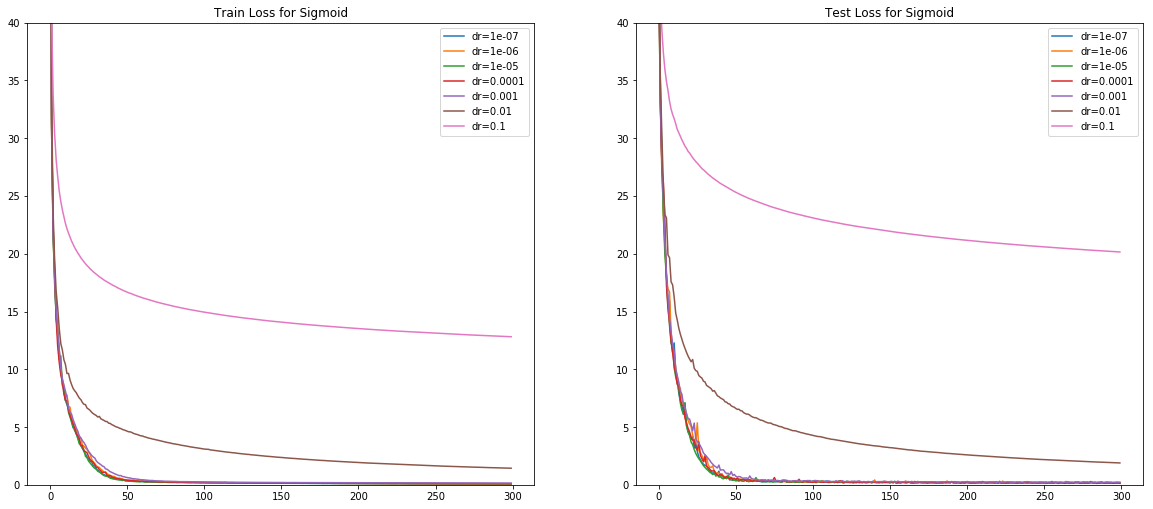

In [15]:
display_stats("Sigmoid", "dr=", 40, sigmoid_loss, sigmoid_val_loss)

En primera instancia, podemos observar un comportamiento inverso a lo que sucedía con el learning rate, esto es, la red converge más rápidamente con valores más pequeños del decay rate. Sin embargo, también podemos observar que valores del decay rate menores o iguales a 0.001 no influyen significativamente en la velocidad de convergencia de la red, aunque sí podemos observar que valores de decay rate de $10^{-5}$ o menor producen visibles variaciones en la curva de error del set de prueba.

Repetimos el mismo análisis para la red con función ReLU:

In [16]:
n_dr = 7
decay_rate = np.logspace(start=-7, stop=-1, num=n_dr, base=10)
relu_loss = {}
relu_val_loss = {}
for dr in decay_rate:
  print("dr="+str(dr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=0.01, decay=dr)
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  relu_loss[dr] = hist.history["loss"]
  relu_val_loss[dr] = hist.history["val_loss"]

dr=1e-07
dr=1e-06
dr=1e-05
dr=0.0001
dr=0.001
dr=0.01
dr=0.1


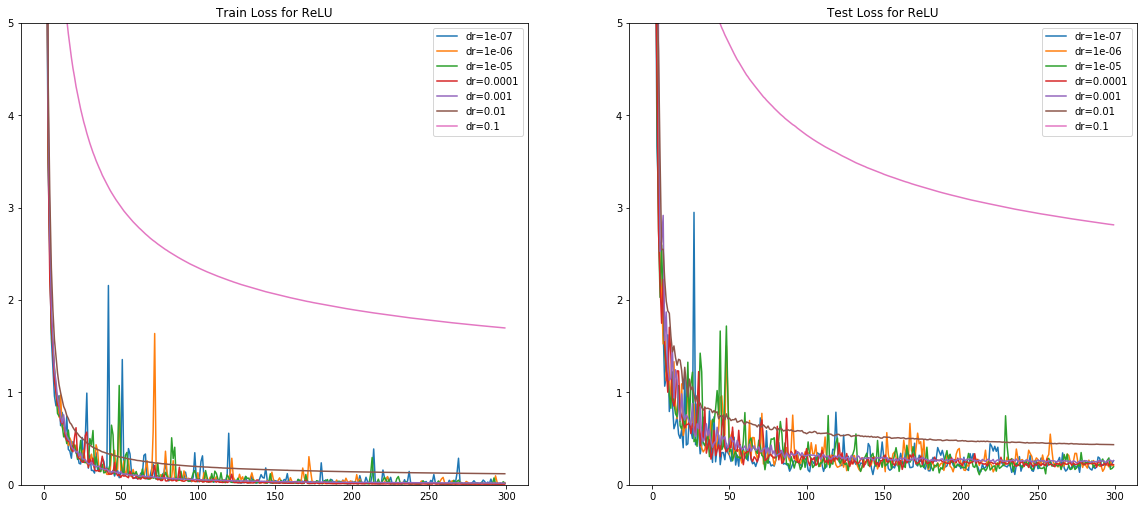

In [17]:
display_stats("ReLU", "dr=", 5, relu_loss, relu_val_loss)

Aquí podemos observar el mismo comportamiento descrito para el caso sigmoidal, esto es, la red converge más rápidamente con valores más pequeños del decay rate y que valores del decay rate menores o iguales a 0.001 no influyen significativamente en la velocidad de convergencia de la red. Sin embargo, podemos observar que los valores de decay rate menores o iguales a 0.001 producen notables variaciones en la curva de error, siendo estas variaciones más intensas en el error del set de pruebas. Aunque estas variaciones no parecen afectar la convergencia de las redes en estudio, no dejan de llamar la atención, y por lo tanto es recomendable operar con valores para el decay rate superiores a 0.01 para evitar estas variaciones.

**Parte f)**

En esta sección entrenaremos los modelos presentados en los puntos b) y c) utilizando mini-batches. Dado que nuestro dataset es de un tamaño reducido, utilizaremos una escala lineal para obtener los tamaños de cada batch a estudiar.

In [18]:
n_batches = 6
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
sigmoid_loss = {}
sigmoid_val_loss = {}
sigmoid_times = {}
for size in batch_sizes:
  size = int(size)
  print("Size="+str(size))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=0.01)
  model.compile(optimizer=sgd,loss='mean_squared_error')
  start = timer()
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      batch_size = size, verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  end = timer()
  sigmoid_loss[size] = hist.history["loss"]
  sigmoid_val_loss[size] = hist.history["val_loss"]
  sigmoid_times[size] = end - start

Size=1
Size=77
Size=152
Size=228
Size=303
Size=379


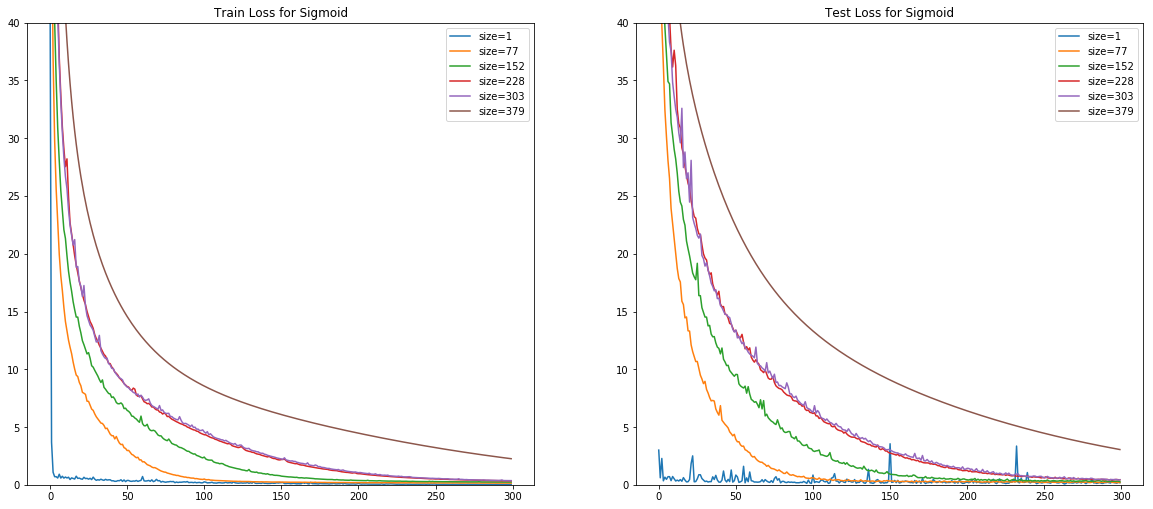

In [19]:
display_stats("Sigmoid", "size=", 40, sigmoid_loss, sigmoid_val_loss)

Aquí podemos observar que, de todas las opciones evaluadas de tamaños de los batches, la opción con batches de tamaño 1 fue la opción con la convergencia más rápida de todas, observando además que a medida que se incrementa el tamaño de los batches, menor es la velocidad de convergencia de la red. Sin embargo, estos gráficos por sí solos no nos cuentan la hsitoria completa, y para eso necesitamos analizar los tiempos de ejecución de las alternativas analizadas.

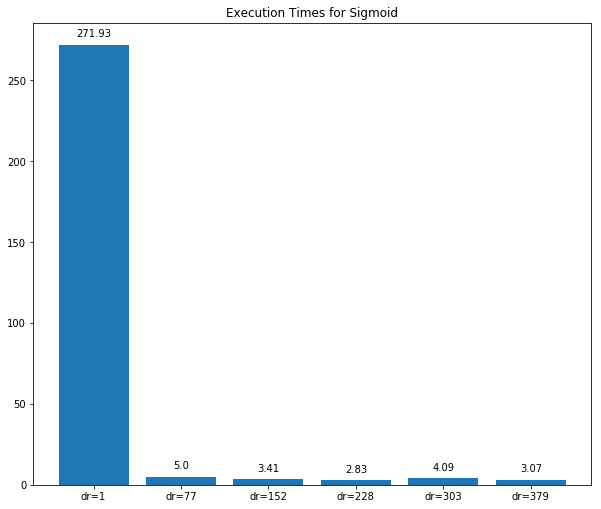

In [20]:
x = np.arange(6)
fig, ax = plt.subplots(figsize=(10, 8.5))
plt.bar(x, sigmoid_times.values())
plt.xticks(x, list(map(lambda x: "dr="+str(x), sigmoid_times.keys())))
for i, v in enumerate(sigmoid_times.values()):
    ax.text(i, v + 5, str(round(v, 2)), color='black', ha='center')
plt.title("Execution Times for Sigmoid")
plt.show()

Si además de analizar la convergencia de las alternativas en estudio analizamos también los tiempos de ejecución de cada una, podemos observar que la alternativa de batches de tamaño 1, aunque la alternativa más rápida en alcanzar convergencia (en número de epochs), es también la alternativa que toma más tiempo en ejecutar los 300 epochs especificados en el modelo. Si además comparamos el tiempo de ejecución de esta alternativa con el resto de las alternativas en estudio, notamos que la opción con batches de tamaño 1 es al menos 2 órdenes de magnitud más lenta que la alternativa siguiente, que es utilizar batches de tamaño 77, la cual toma menos de 10 segundos en ejecutar los 300 epochs especificados en la definición de la red. Esto hace necesario establecer un equilibrio entre la rapidez de convergencia deseada y el tiempo que nos tomará el entrenamiento de la red, donde la opción de utilizar batches de tamaño 77 surge como la opción más adecuada bajo este criterio.

In [21]:
n_batches = 6
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
relu_loss = {}
relu_val_loss = {}
relu_times = {}
for size in batch_sizes:
  size = int(size)
  print("Size="+str(size))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=0.01)
  model.compile(optimizer=sgd,loss='mean_squared_error')
  start = timer()
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      batch_size = size, verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  end = timer()
  relu_loss[size] = hist.history["loss"]
  relu_val_loss[size] = hist.history["val_loss"]
  relu_times[size] = end - start

Size=1
Size=77
Size=152
Size=228
Size=303
Size=379


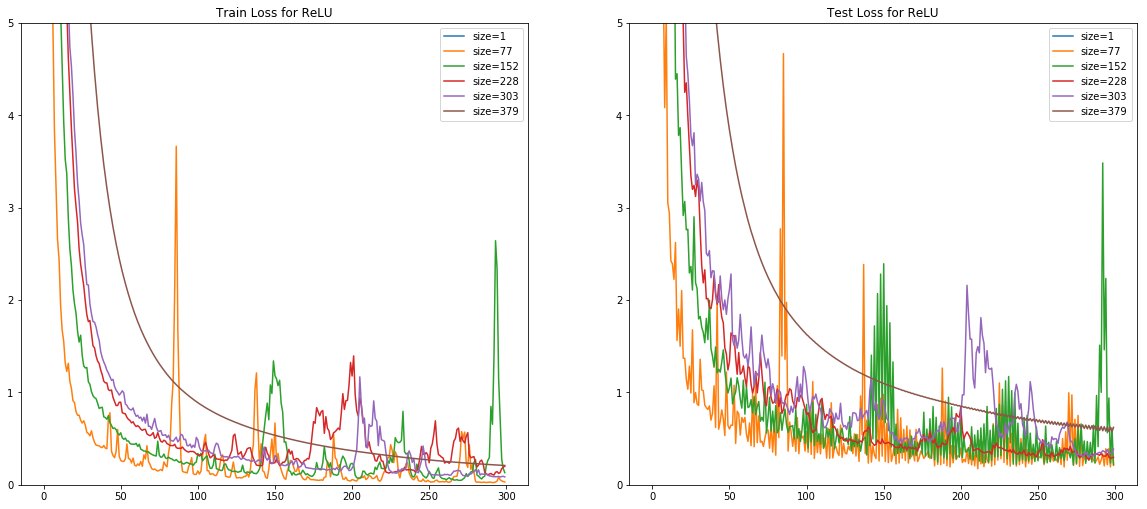

In [22]:
display_stats("ReLU", "size=", 5, relu_loss, relu_val_loss)

Aquí se puede observar una tendencia similar a la que analizamos anteriormente, pero con algunas diferencias bastante notorias. Primero, la curva de error del set de prueba para batches de tamaño 379 parecen aumentar su valor a partir de los 250 epochs, y en el caso del error del set de prueba presenta unas variaciones bastante marcadas a partir de los 250 epochs. Además, para todos los casos estudiados, se aprecia que todas las curvas de error presentan variaciones, siendo las curvas de error del set de prueba las más afectadas. Sin embargo, estas variaciones (exceptuando la curva de error para el batch de tamaño 379) no parecen afectar la convergencia del modelo, sobre todo con tamaños de batch más reducidos. Otra cosa importante a mencionar es la ausencia de la curva de error para el caso de bacthes de tamaño 1, debido a que en este caso la red no logra alcanzar convergencia en sus parámetros.

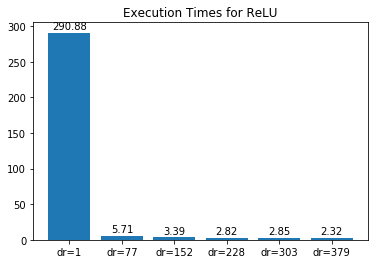

In [23]:
x = np.arange(6)
fig, ax = plt.subplots()
plt.bar(x, relu_times.values())
plt.xticks(x, list(map(lambda x: "dr="+str(x), relu_times.keys())))
for i, v in enumerate(relu_times.values()):
    ax.text(i, v + 5, str(round(v, 2)), color='black', ha='center')
plt.title("Execution Times for ReLU")
plt.show()

De la misma forma que en el caso sigmoidal, analizamos los tiempos de ejecución para cada alternativa en estudio. Al igual que en el caso anterior, la alternativa de batches de tamaño 1 es la que más tiempo toma entre todas, siendo órdenes de magnitud más lenta que el resto de las alternativas. Sin embargo esta alternativa no es viable, dado que esta alternativa no lleva a la red a un estado de convergencia. Al igual que en el caso anterior, la opción de utilizar batches de tamaño 77 (o menor) emerge como la opción más apropiada, dado que es la que presenta la curva de error con la menor cantidad de variaciones de entre las opciones en estudio.

**Parte g)**

A continuación, entrenaremos los modelos presentados en los puntos b) y c) utilizando técnicas modernas para adaptar el learning rate, más especificamente, Adegrad, Adadelta, RMSprop y adam. Tal como lo hicimos en la parte d), utilizamos una escala logarítmica para variar los valores del learning rate, desde $10^{-5}$ hasta $10^{-1}$.

> 1- **Adagrad**


In [24]:
n_lr = 5
lear_rate = np.logspace(start=-5, stop=-1, num=n_lr, base=10)
sigmoid_loss = {}
sigmoid_val_loss = {}
for lr in lear_rate:
  print("lr = "+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  moptimizer = Adagrad(lr=lr) #Con lr más de 0.025, hell breaks loose.
  model.compile(optimizer=moptimizer,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  sigmoid_loss[lr] = hist.history["loss"]
  sigmoid_val_loss[lr] = hist.history["val_loss"]

lr = 1e-05
lr = 0.0001
lr = 0.001
lr = 0.01
lr = 0.1


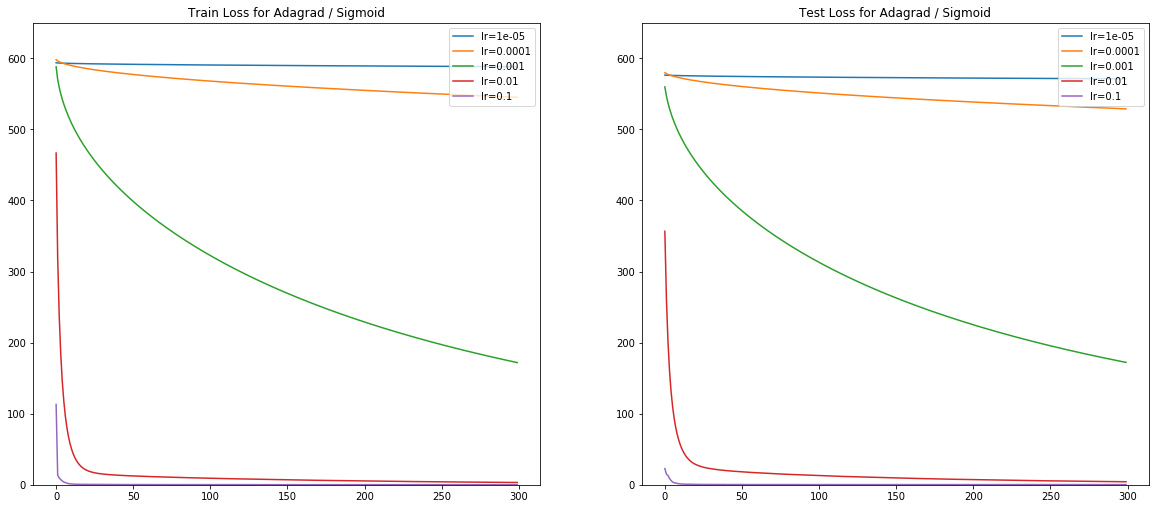

In [25]:
display_stats("Adagrad / Sigmoid", "lr=", 650, sigmoid_loss, sigmoid_val_loss)

Como podemos observar, las curvas de error para Adagrad+Sigmoidal son bastante distintas a las de Sigmoidal por sí sola. En primer lugar, la utilización de un learning rate de 0.1 ya no ocasiona la divergencia del modelo, sino que es la opción que más rápido alcanza la convergencia de todas las opciones en estudio. Además, la utilización de un learning rate de $10^{-5}$ en nuestro modelo da como resultado la convergencia más lenta de todas las opciones en estudio, haciendo que en 300 epochs el error disminuya en una cantidad que difícilmente es posible notar.

In [26]:
n_lr = 5
lear_rate = np.logspace(start=-5, stop=-1, num=n_lr, base=10)
relu_loss = {}
relu_val_loss = {}
for lr in lear_rate:
  print("lr="+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  moptimizer = Adagrad(lr=lr)
  model.compile(optimizer=moptimizer,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  relu_loss[lr] = hist.history["loss"]
  relu_val_loss[lr] = hist.history["val_loss"]

lr=1e-05
lr=0.0001
lr=0.001
lr=0.01
lr=0.1


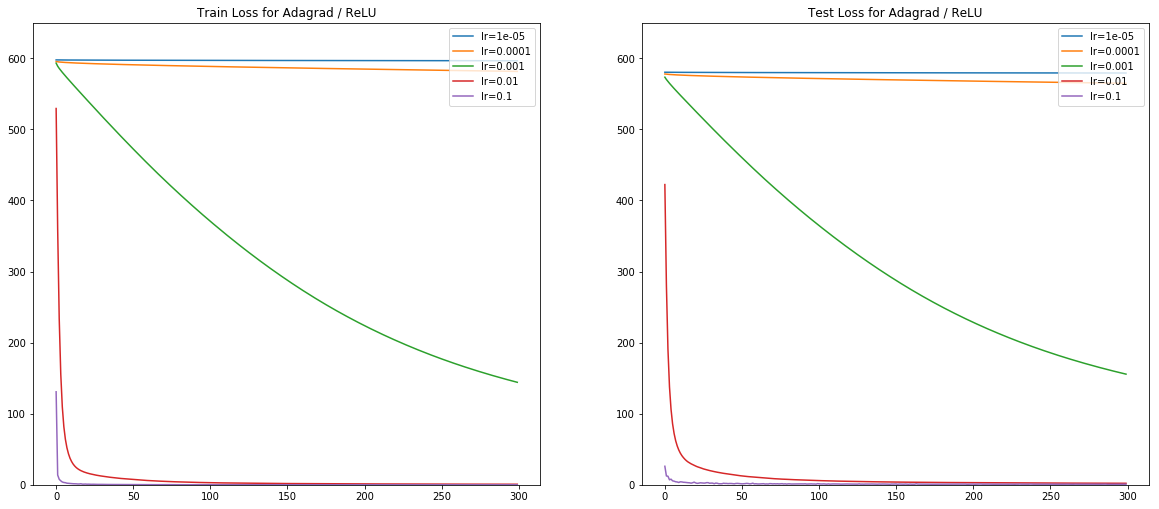

In [27]:
display_stats("Adagrad / ReLU", "lr=", 650, relu_loss, relu_val_loss)

Para el caso de Adagrad+ReLU la situación es similar al caso de Adagrad+Sigmoidal, presentando las mismas situaciones que discutimos en el caso anterior. La única diferencia es que la convergencia más lenta está dada por la utilización de un valor de learning rate de $10^{-4}$ o $10^{-5}$, donde $10^{-5}$ continúa siendo el learning rate más "lento" utilizando Adagrad.

> 2- **Adadelta**


In [28]:
n_lr = 6
lear_rate = np.logspace(start=-5, stop=0, num=n_lr, base=10)
sigmoid_loss = {}
sigmoid_val_loss = {}
for lr in lear_rate:
  print("lr = "+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  moptimizer = Adadelta(lr=lr) #Con lr más de 0.025, hell breaks loose.
  model.compile(optimizer=moptimizer,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  sigmoid_loss[lr] = hist.history["loss"]
  sigmoid_val_loss[lr] = hist.history["val_loss"]

lr = 1e-05
lr = 0.0001
lr = 0.001
lr = 0.01
lr = 0.1
lr = 1.0


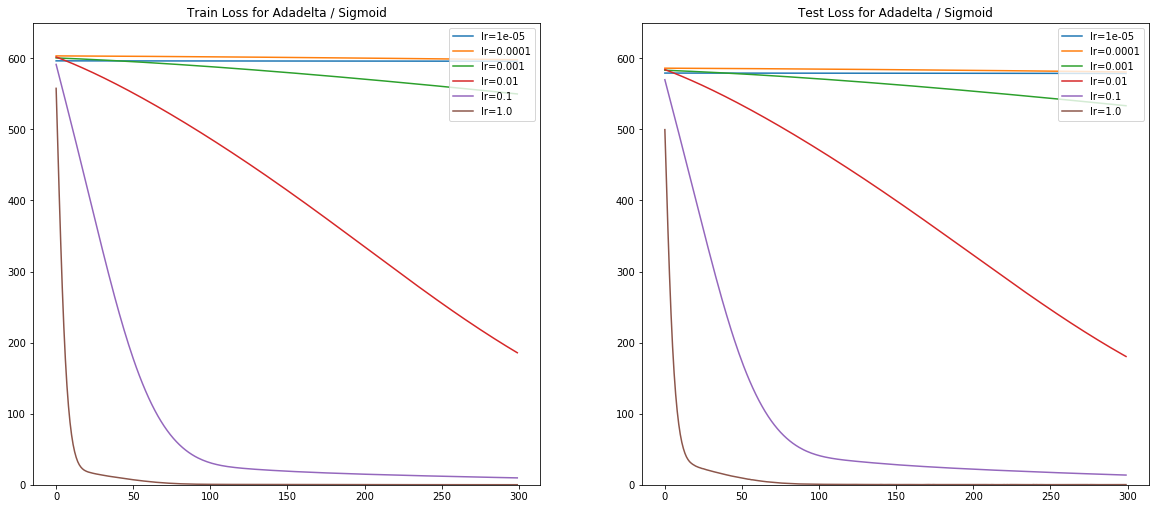

In [29]:
display_stats("Adadelta / Sigmoid", "lr=", 650, sigmoid_loss, sigmoid_val_loss)

Para el caso de Adadelta+Sigmoidal se presenta una situación similar a lo presentado para Adagrad, en donde la diferencia en las velocidades de convergencia para cada learning rate probado es bastante notable, sobre todo entre los valores más grandes. Algo importante a recalcar es que la velocidad de convergencia más grande para este caso corresponde a un learning rate de 1.0, algo que no era ni remotamente posible utilizando funciones sigmoidales o ReLU + SGD, y que es gracias a las características adaptativas del método en estudio.

In [30]:
n_lr = 6
lear_rate = np.logspace(start=-5, stop=0, num=n_lr, base=10)
relu_loss = {}
relu_val_loss = {}
for lr in lear_rate:
  print("lr="+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  moptimizer = Adadelta(lr=lr)
  model.compile(optimizer=moptimizer,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  relu_loss[lr] = hist.history["loss"]
  relu_val_loss[lr] = hist.history["val_loss"]

lr=1e-05
lr=0.0001
lr=0.001
lr=0.01
lr=0.1
lr=1.0


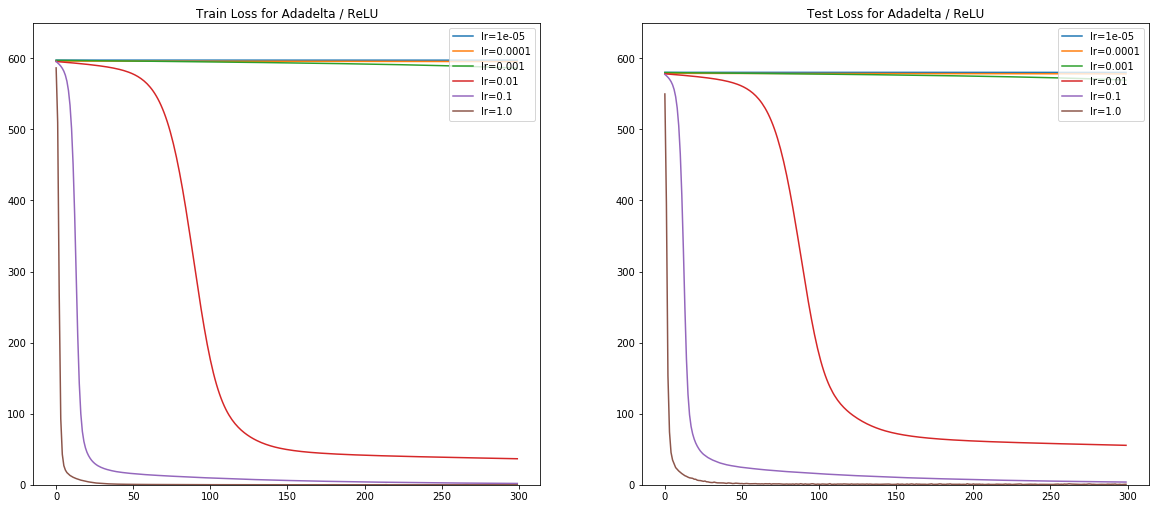

In [31]:
display_stats("Adadelta / ReLU", "lr=", 650, relu_loss, relu_val_loss)

Para el caso de Adadelta+ReLU observamos un comportamiento similar al de Adadelta+Sigmoidal, pero la diferencia entre las velocidades de convergencia de los learning rates más grandes no es tan marcada como fue en el caso anterior. Además, y tal como en el caso anterior, el surgimiento de un learning rate de 1.0 como la alternativa con la convergencia más rápida no deja de sorprender, considerando que los modelos presentados en b) y c) divergen con valores de learning rate cercanos a 0.1.

> 3- **Adam**

In [32]:
n_lr = 5
lear_rate = np.logspace(start=-5, stop=-1, num=n_lr, base=10)
sigmoid_loss = {}
sigmoid_val_loss = {}
for lr in lear_rate:
  print("lr = "+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  moptimizer = Adam(lr=lr) #Con lr más de 0.025, hell breaks loose.
  model.compile(optimizer=moptimizer,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  sigmoid_loss[lr] = hist.history["loss"]
  sigmoid_val_loss[lr] = hist.history["val_loss"]

lr = 1e-05
lr = 0.0001
lr = 0.001
lr = 0.01
lr = 0.1


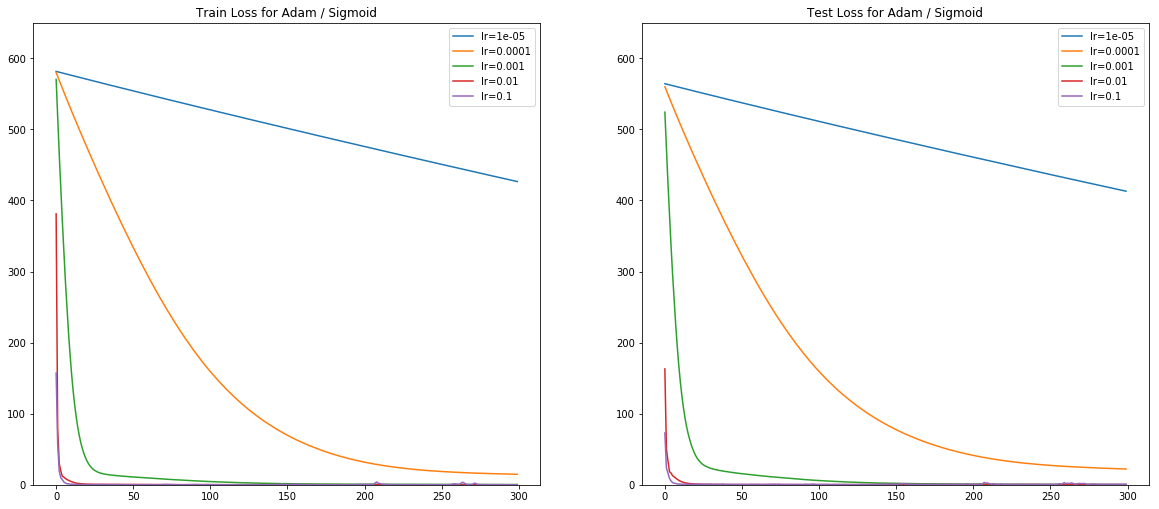

In [33]:
display_stats("Adam / Sigmoid", "lr=", 650, sigmoid_loss, sigmoid_val_loss)

En el caso de Adam+Sigmoidal se observa la misma tendencia que observamos con las últimas 2 técnicas, esto es, valores más pequeños del learning rate producen mayores velocidades de convergencia en el modelo en cuestión. En este caso en particular, un learning rate de 0.01 o de 0.1 producirán una velocidad de convergencia similiar, siendo un learning rate de 0.1 levemente superior.

In [34]:
n_lr = 5
lear_rate = np.logspace(start=-5, stop=-1, num=n_lr, base=10)
relu_loss = {}
relu_val_loss = {}
for lr in lear_rate:
  print("lr="+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  moptimizer = Adam(lr=lr)
  model.compile(optimizer=moptimizer,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  relu_loss[lr] = hist.history["loss"]
  relu_val_loss[lr] = hist.history["val_loss"]

lr=1e-05
lr=0.0001
lr=0.001
lr=0.01
lr=0.1


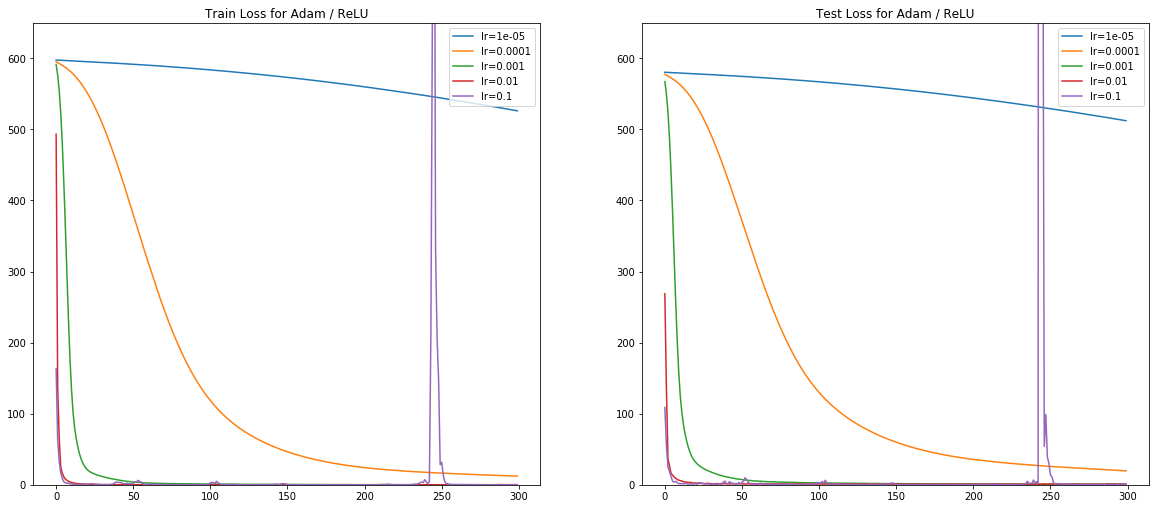

In [35]:
display_stats("Adam / ReLU", "lr=", 650, relu_loss, relu_val_loss)

Para el caso de Adam+ReLU observamos una situación similar a lo ocurrido con Adem+sigmoidal, donde la única diferencia es la presencia de pequeñas variaciones en la curva de error para un learning rate de 0.1, variaciones que no afectan la velocidad de convergencia del modelo con dicho valor. Las velocidades de convergencia para ReLU son algo mayores a las de sigmoidal, pero en esencia el comportamiento de las velocidades de convergencia de las diferentes alternativas de learning rate es el mismo.

> 4- **RMSprop**

In [36]:
n_lr = 5
lear_rate = np.logspace(start=-5, stop=-1, num=n_lr, base=10)
sigmoid_loss = {}
sigmoid_val_loss = {}
for lr in lear_rate:
  print("lr = "+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  moptimizer = RMSprop(lr=lr) #Con lr más de 0.025, hell breaks loose.
  model.compile(optimizer=moptimizer,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  sigmoid_loss[lr] = hist.history["loss"]
  sigmoid_val_loss[lr] = hist.history["val_loss"]

lr = 1e-05
lr = 0.0001
lr = 0.001
lr = 0.01
lr = 0.1


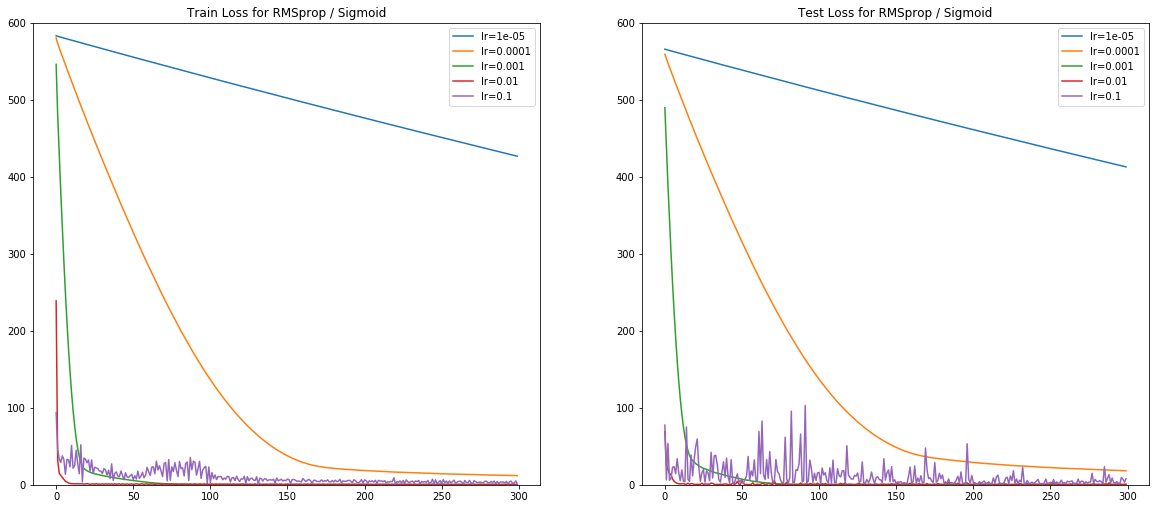

In [37]:
display_stats("RMSprop / Sigmoid", "lr=", 600, sigmoid_loss, sigmoid_val_loss)

El caso de RMSprop+Sigmoidal presenta muchas similitudes respecto a lo que sucede con Adam+Sigmoidal, principalmente por el hecho de que las curvas de error para cada una de las opciones de learning rate en estudio son bastante similares entre ambas técnicas, por lo que las conclusiones serán las mismas que fueron expresadas para el caso Adam+Sigmoidal. La única salvedad de esta similitud entre técnicas es la curva de error para un learning rate de 0.1, la cual presenta varias variaciones que disminuyen su intensidad a medida que aumenta el número de epochs, pero que no parecen afectar en mayor medida la convergencia del modelo bajo esta opción.

In [38]:
n_lr = 5
lear_rate = np.logspace(start=-5, stop=-1, num=n_lr, base=10)
relu_loss = {}
relu_val_loss = {}
for lr in lear_rate:
  print("lr="+str(lr))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  moptimizer = RMSprop(lr=lr)
  model.compile(optimizer=moptimizer,loss='mean_squared_error')
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  relu_loss[lr] = hist.history["loss"]
  relu_val_loss[lr] = hist.history["val_loss"]

lr=1e-05
lr=0.0001
lr=0.001
lr=0.01
lr=0.1


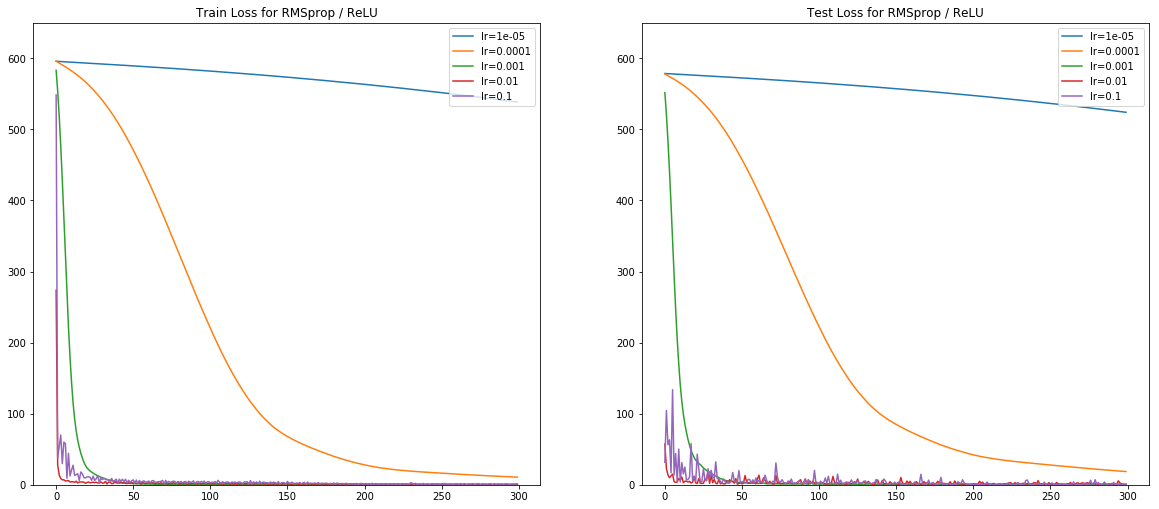

In [39]:
display_stats("RMSprop / ReLU", "lr=", 650, relu_loss, relu_val_loss)

De las misma manera que en el caso estudiado anteriormente, lo que sucede con RMSprop+ReLU es similar a lo que ocurre con Adam+ReLU, por las mismas razones expresadas en el caso anterior, por lo que las conclusiones serán las mismas que las expresadas para el caso Adam+ReLU. Al igual que con el caso anterior, la única salvedad a esta "igualdad" entre técnicas es la curva de error para un learning rate de 0.1, la cual presenta una serie variaciones cuya intensidad disminuye a medida que aumenta el número de epochs, y que no afecta en mayor medida a la convergencia del modelo bajo estas condiciones.

**Parte h)**

En esta sección, entrenaremos los modelos presentados en los puntos b) y c) utilizando regularizadores $l_1$ y $l_2$, conocidos como *weight decay*. Analizaremos el efecto que tiene su utilización sobre el error del modelo, así como los efectos que tienen distintos valores del parámetro de regularización.

Dada la cantidad de posibles combinaciones de regularizadores, capas regularizadas y funciones de activación posible, y considerando las restricciones que tenemos como estudiantes, es que estudiaremos algunas de estas posibilidades. Concretamente, estudiaremos el efecto de utilizar reguladores $l_1$ y $l_2$ sobre ambas capas de los modelos b) y c), así como los efectos de regularizar sólo una de las dos capas para el caso del modelo b).

Para simplificar nuestra labor, definimos una función que nos ayuda a definir el modelo con los parámetros requeridos, esto es: función de activación, regulazidadores a utilizar y capas del modelo a ser reguladas.

In [0]:
def model_with_reg(act_function, reg_type, layers_reg):
  #act_function: sigmoid or relu
  #reg_type: 1 or 2
  #layers_reg: all, 1 or 2
  n_reg = 5
  reg_rate = np.logspace(start=-5, stop=-1, num=n_reg, base=10)
  model_loss = {}
  model_val_loss = {}
  for reg in reg_rate:
    print("reg = "+str(reg))
    model = Sequential()
    if layers_reg == "1" or layers_reg == "all":
      if reg_type == "1":
        model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform', kernel_regularizer=l1(reg)))
      else:
        model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform', kernel_regularizer=l2(reg)))
    else:
      model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
    model.add(Activation(act_function))
    if layers_reg == "2" or layers_reg == "all":
      if reg_type == "1":
        model.add(Dense(1, kernel_initializer='uniform', kernel_regularizer=l1(reg)))
      else:
        model.add(Dense(1, kernel_initializer='uniform', kernel_regularizer=l2(reg)))
    else:
      model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    sgd = SGD(lr=0.01) #Con lr más de 0.025, hell breaks loose.
    model.compile(optimizer=sgd,loss='mean_squared_error')
    hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
        verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
    model_loss[reg] = hist.history["loss"]
    model_val_loss[reg] = hist.history["val_loss"]
  return (model_loss, model_val_loss)

 >1- **Sigmoid / $l_1$ / Ambas Capas**

In [41]:
sigmoid_loss, sigmoid_val_loss = model_with_reg('sigmoid', '1', 'all')

reg = 1e-05
reg = 0.0001
reg = 0.001
reg = 0.01
reg = 0.1


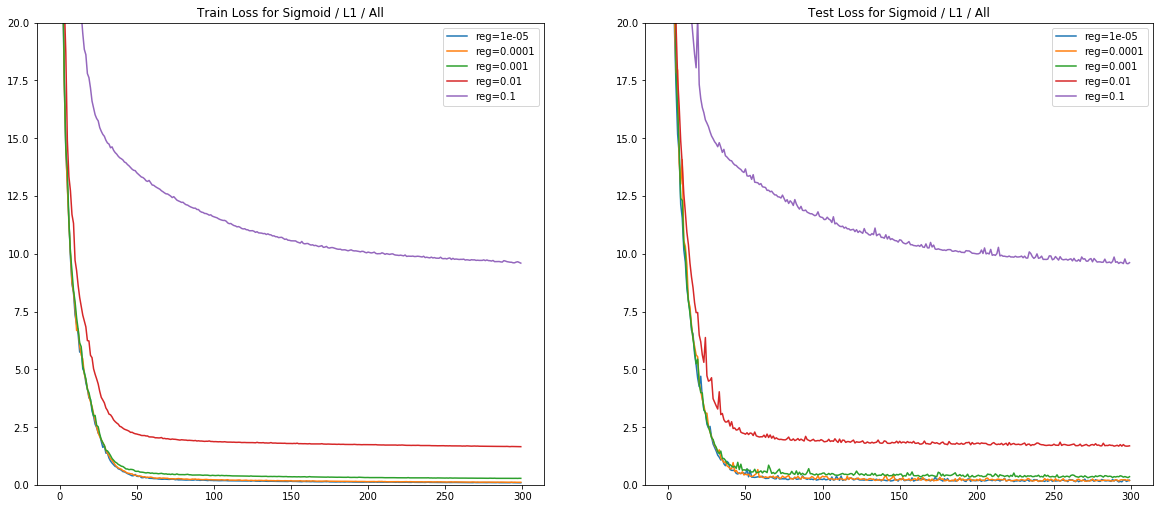

In [42]:
display_stats("Sigmoid / L1 / All", "reg=", 20, sigmoid_loss, sigmoid_val_loss)

Hay varias cosas que podemos observar en este caso. Primero, que valores más grandes del parámetro de regularización producen que el modelo converja a valores de error más altos en ambos sets, donde la congergencia a errores más pequeños se observa con valores del parámetro de regularización iguales a 0.0001 o menores. Además, las curvas de error para valores del parámetro de regularización de 0.0001 y 0.00001 son bastante similares en forma y magnitudes, por lo que se entiende que valores del parámetro de regularización inferiores a 0.0001 no lograrán aumentar la velocidad de convergencia o el valor del error al que se converge más de lo que ya ha logrado este valor.

Si además comparamos estas curvas de error a las obtenidas en el punto b), notamos que las mejores curvas de error en este caso no mejoran de forma significativa la curva de error presentada en dicho punto, esto es, la adición del regularizador con los mejores parámetros en estudio no parece brindar mejoras significativas a la velocidad de convergencia del modelo, o al valor del error al que este converge. 

 >2- **Sigmoid / $l_2$ / Ambas Capas**

In [43]:
sigmoid_loss, sigmoid_val_loss = model_with_reg('sigmoid', '2', 'all')

reg = 1e-05
reg = 0.0001
reg = 0.001
reg = 0.01
reg = 0.1


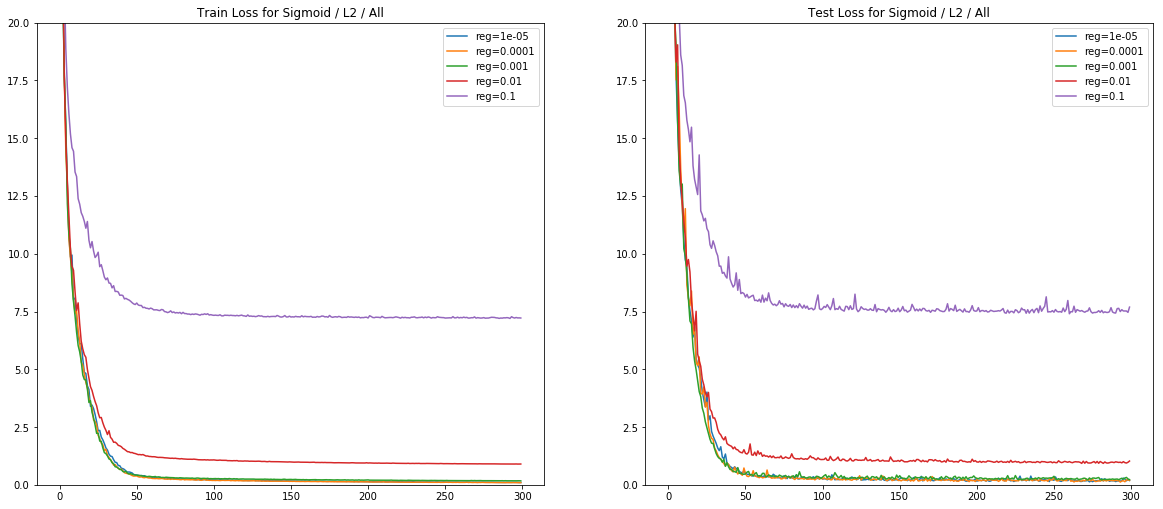

In [44]:
display_stats("Sigmoid / L2 / All", "reg=", 20, sigmoid_loss, sigmoid_val_loss)

El cambio de $l_1$ a $l_2$ como regularizador en el modelo Sigmoidal no introduce mayores diferencias en las curvas de error para ambos sets, salvo una velocidad de convergencia levemente mayor (lo que se puede notar en mayor medida en la curva de error para un parámetro de regularización de 0.1), y una disminución en el valor del error al que converge cada una de las curvas de error. Dado que el cambio de regulalizador no produce mayores diferencias en las curvas de error, las conclusiones en este caso son las mismas, es decir, la adición del regularizador con los mejores parámetros en estudio no parece brindar mejoras significativas a la velocidad de convergencia del modelo, o al valor del error al que este converge.

 >3- **ReLU / $l_1$ / Ambas Capas**

In [45]:
relu_loss, relu_val_loss = model_with_reg('relu', '1', 'all')

reg = 1e-05
reg = 0.0001
reg = 0.001
reg = 0.01
reg = 0.1


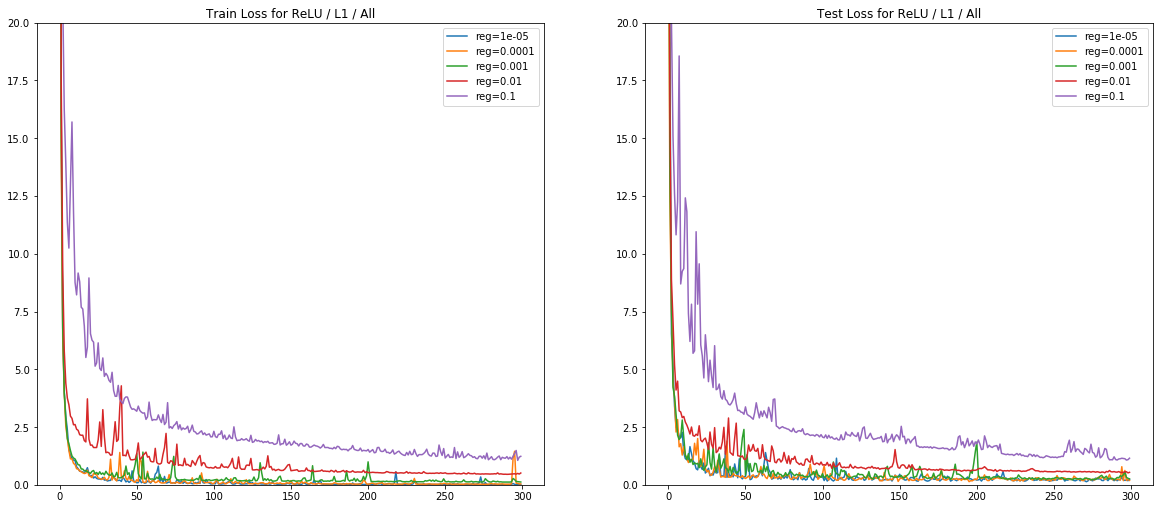

In [46]:
display_stats("ReLU / L1 / All", "reg=", 20, relu_loss, relu_val_loss)

Aquí observamos algunas diferencias notorias comparado a lo que sucedió con el modelo Sigmoidal. Lo primero es que todas las curvas de error convergen a valores aparentemente mucho más reducidos comparados a sus contrapartes del modelo Sigmoidal, pero además las curvas de error presentan variaciones que son más notorias que las presentadas por las curvas de erorr del modelo Sigmoidal. Además, y al igual que lo sucedido con el modelo Sigmoidal, notamos que las mejores curvas de error en este caso no mejoran de forma significativa lo planteado en el punto c), es decir, la adición del regularizador con los mejores parámetros en estudio no parece brindar mejoras significativas a la velocidad de convergencia del modelo, o al valor del error al que este converge. 

 >4- **ReLU / $l_2$ / Ambas Capas**

In [47]:
relu_loss, relu_val_loss = model_with_reg('relu', '2', 'all')

reg = 1e-05
reg = 0.0001
reg = 0.001
reg = 0.01
reg = 0.1


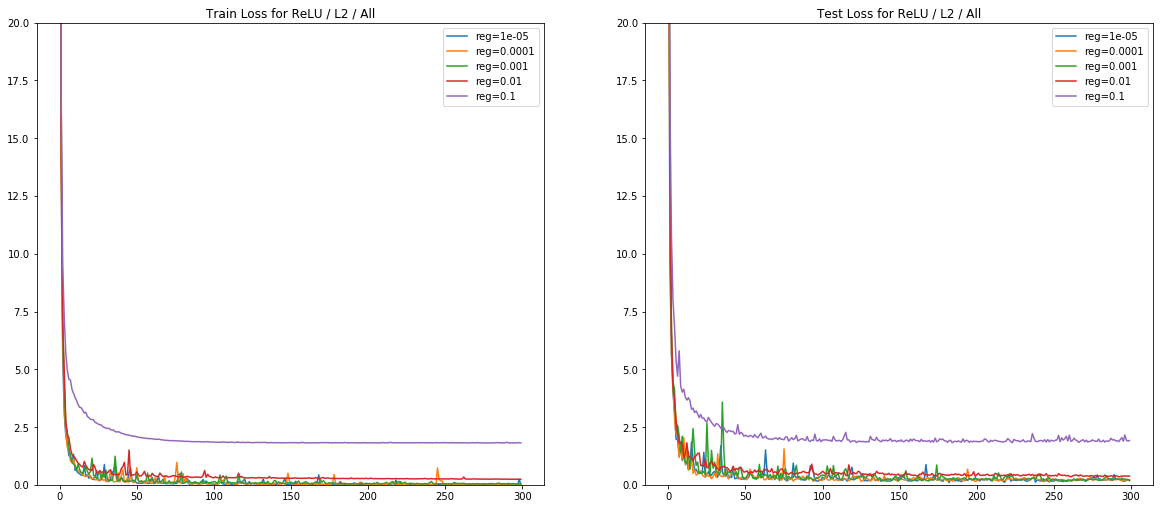

In [48]:
display_stats("ReLU / L2 / All", "reg=", 20, relu_loss, relu_val_loss)

El cambio de regularizador de $l_1$ a $l_2$ aumenta la velocidad de convergencia de todas las alternativas en estudio, logrando convergencia en alrededor de 50 epochs; esta mejora en la velocidad de convergencia es más notoria en el caso de la curva de error para un valoar de parámetro de regularización igual a 0.1. Las conclusiones en este caso siguen siendo las mismas que hemos mencionado en los últimos 3 casos, es decir, la adición del regularizador con los mejores parámetros en estudio no parece brindar mejoras significativas a la velocidad de convergencia del modelo, o al valor del error al que este converge.

 >5- **ReLU / $l_2$ / Primera Capa v/s Segunda Capa**

In [49]:
relu_loss_1, relu_val_loss_1 = model_with_reg('relu', '2', '1')

reg = 1e-05
reg = 0.0001
reg = 0.001
reg = 0.01
reg = 0.1


In [50]:
relu_loss_2, relu_val_loss_2 = model_with_reg('relu', '2', '2')

reg = 1e-05
reg = 0.0001
reg = 0.001
reg = 0.01
reg = 0.1


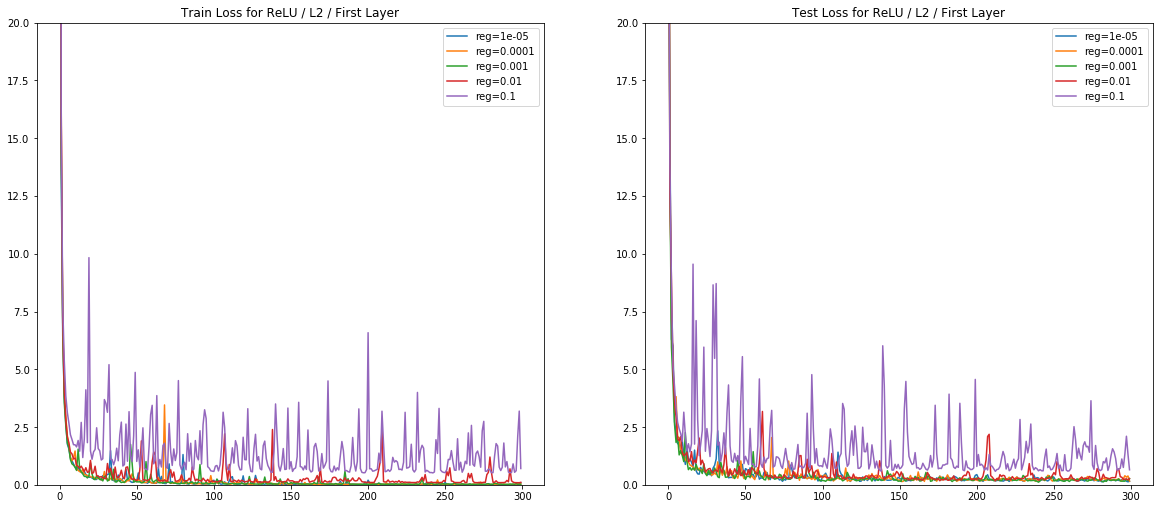

In [51]:
display_stats("ReLU / L2 / First Layer", "reg=", 20, relu_loss_1, relu_val_loss_1)

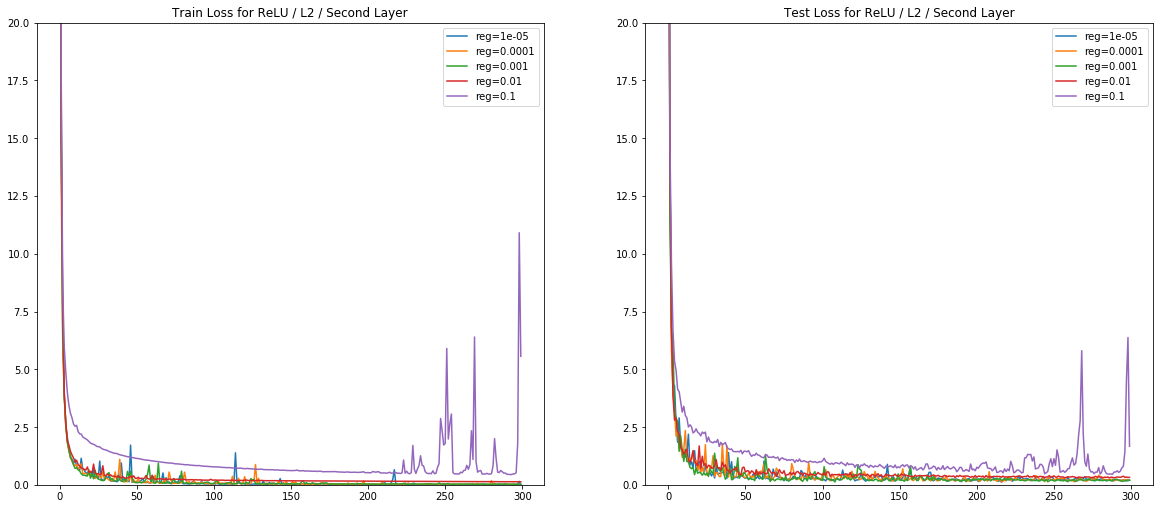

In [52]:
display_stats("ReLU / L2 / Second Layer", "reg=", 20, relu_loss_2, relu_val_loss_2)

De estos gráficos podemos observar que, si bien las curvas de error en ambas situaciones presentan un comportamiento similar (esto es, presentan una velocidad de convergencia similar y hacia valores de error similares), las curvas de error de la regularización de la segunda capa son en general más limpias que las curvas de error de la primera capa, presentando estas últimas una alta cantidad de variaciones, sobre todo las curvas de error correspondientes al uso de un parámetro de regularización igual a 0.1.

In [53]:
relu_loss_1, relu_val_loss_1 = model_with_reg('relu', '1', '1')
relu_loss_2, relu_val_loss_2 = model_with_reg('relu', '1', '2')

reg = 1e-05
reg = 0.0001
reg = 0.001
reg = 0.01
reg = 0.1
reg = 1e-05
reg = 0.0001
reg = 0.001
reg = 0.01
reg = 0.1


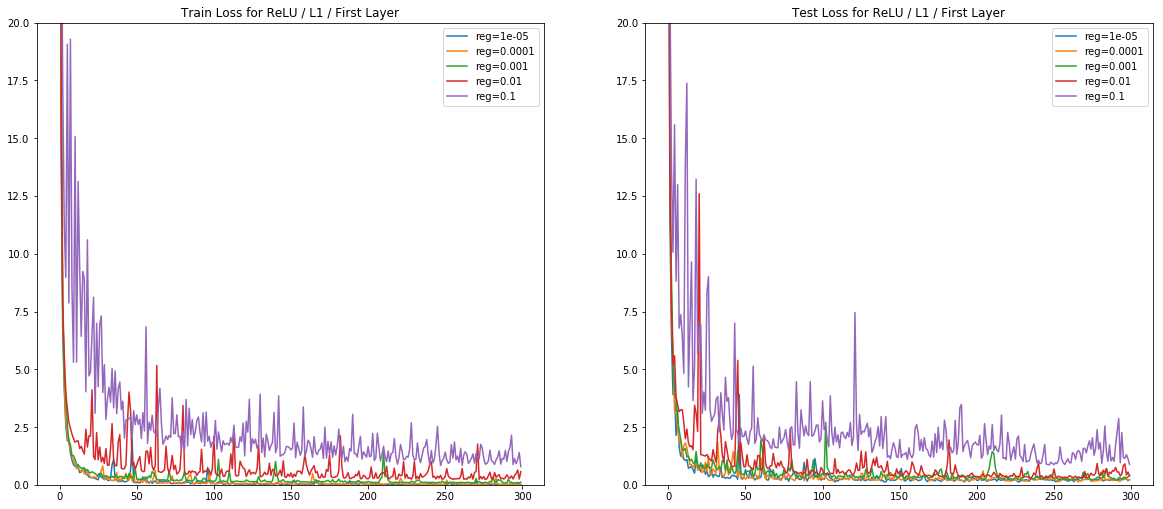

In [54]:
display_stats("ReLU / L1 / First Layer", "reg=", 20, relu_loss_1, relu_val_loss_1)

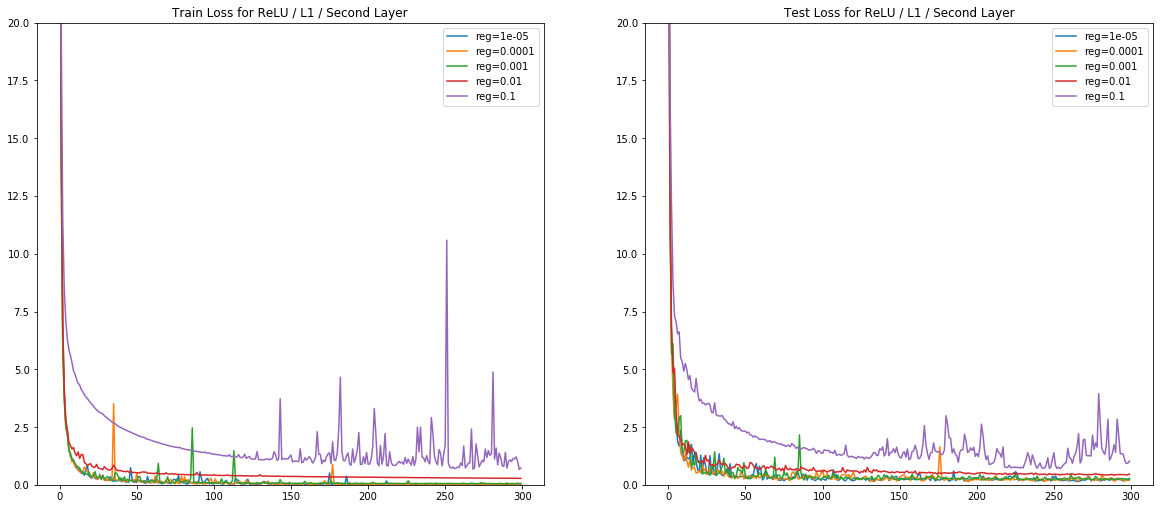

In [55]:
display_stats("ReLU / L1 / Second Layer", "reg=", 20, relu_loss_2, relu_val_loss_2)

La misma situación se da si pasamos de un regularizador $l_1$ a un regularizador $l_2$, donde las curvas de error de la segunda capa son en general más limpias que las curvas de error de la primera capa. Cabe destacar, en este caso, que las curvas de la segunda capa comienzan a mostrar variaciones a partir de los 150 epochs, pero aún considerando este hecho estas curvas son en general más limpias que las curvas de error de la primera capa.

**Parte i)**

En esta sección aplicaremos Dropout a los modelos presentados en los puntos b) y c). Tal como lo hemos hecho en secciones anteriores, utilizamos una escala logarítmica para variar los valores del parámetro de regularización, desde $10^{-5}$ hasta $10^{-0}$. Dado que la misión de Dropout es prevenir el overfitting, compararemos el accuracy del modelo antes y después de la aplicación del Dropout, además del error del mismo.

> 1- **Modelo Sigmoidal**

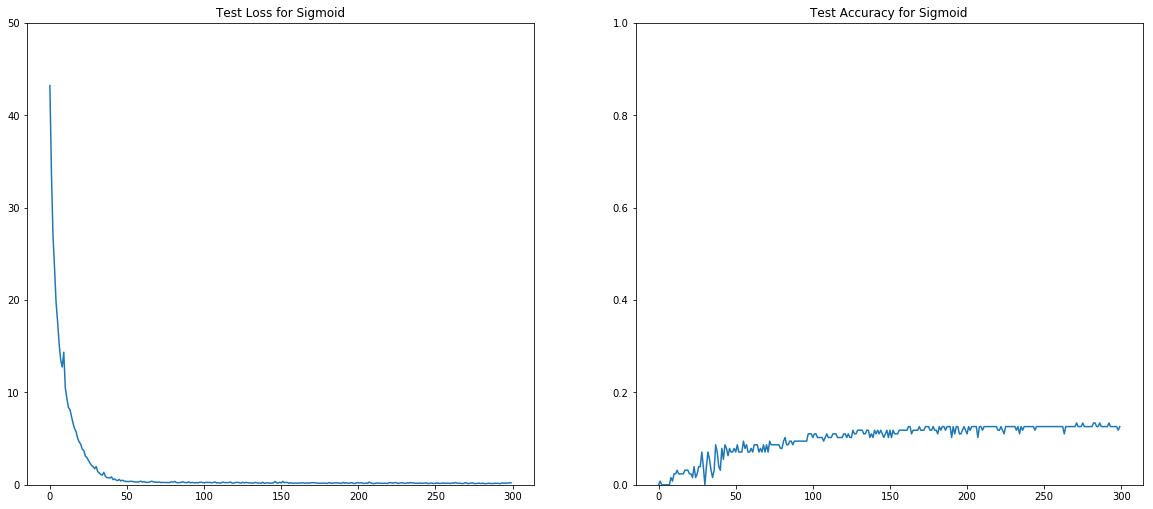

In [56]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy'])
hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

ax1.plot(range(0, 300), hist.history['val_loss'])
ax1.set_ylim(ymax=50, ymin=0)
ax1.set_title("Test Loss for Sigmoid")

ax2.plot(range(0, 300), hist.history['val_acc'])
ax2.set_ylim(ymax=1, ymin=0)
ax2.set_title("Test Accuracy for Sigmoid")

plt.show()

In [57]:
n_reg = 6
reg_rate = np.logspace(start=-5, stop=0, num=n_reg, base=10)
sigmoid_loss = {}
sigmoid_val_loss = {}
sigmoid_acc = {}
sigmoid_val_acc = {}
for reg in reg_rate:
  print("reg="+str(reg))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dropout(reg))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=0.01) #Con lr más de 0.025, hell breaks loose.
  model.compile(optimizer=sgd,loss='mean_squared_error', metrics=['accuracy'])
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  sigmoid_loss[reg] = hist.history["loss"]
  sigmoid_val_loss[reg] = hist.history["val_loss"]
  sigmoid_acc[reg] = hist.history["acc"]
  sigmoid_val_acc[reg] = hist.history["val_acc"]

reg=1e-05
reg=0.0001
reg=0.001
reg=0.01
reg=0.1
reg=1.0


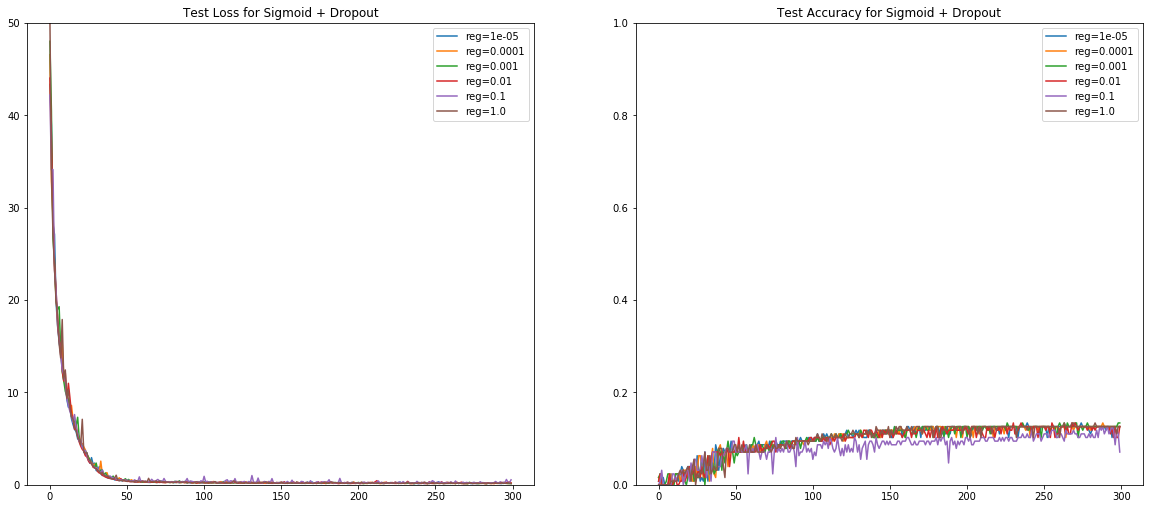

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

legend = []
for lr, loss in list(sigmoid_val_loss.items()):
  ax1.plot(range(0, 300), loss)
  legend.append("reg="+str(lr))

ax1.set_ylim(ymax=50, ymin=0)
ax1.set_title("Test Loss for Sigmoid + Dropout")
ax1.legend(legend, loc='upper right')

legend = []
for lr, loss in list(sigmoid_val_acc.items()):
  ax2.plot(range(0, 300), loss)
  legend.append("reg="+str(lr))

ax2.set_ylim(ymax=1, ymin=0)
ax2.set_title("Test Accuracy for Sigmoid + Dropout")
ax2.legend(legend, loc='upper right')

plt.show()

Al comparar los gráficos para el modelo sigmoidal antes y después de la aplicación del Dropout, se puede observar que no existen mayores diferencias entre los errores y las exactitudes de los modelos en ambas situaciones, independiente del valor del parámetro de regularización utilizado. Esto puede deberse a lo reducido de nuestro dataset, o a que el modelo origina no sufría de overfitting (que es lo que Dropout busca evitar).

> 2- **Modelo ReLU**

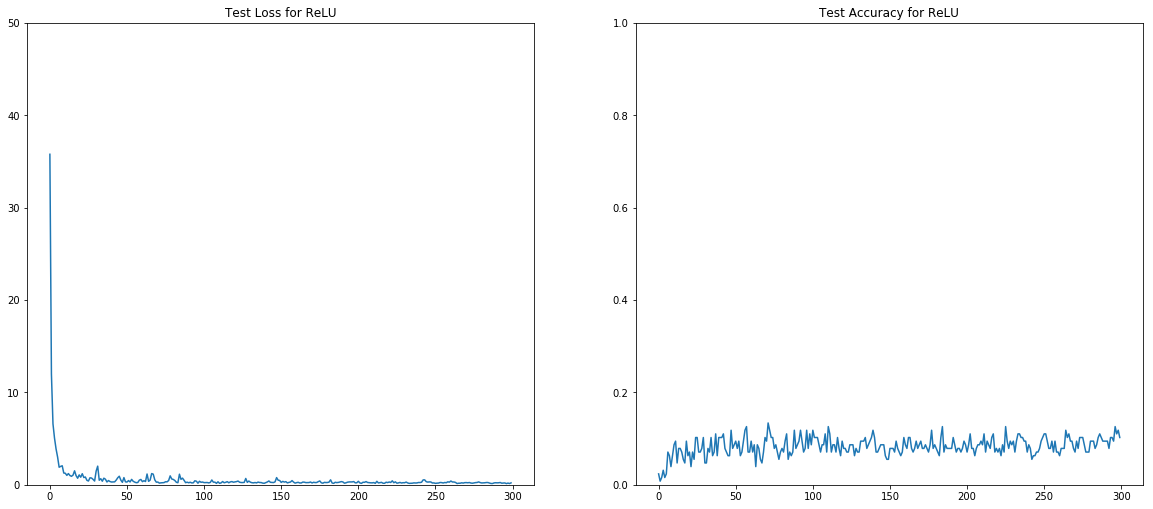

In [59]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy'])
hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

ax1.plot(range(0, 300), hist.history['val_loss'])
ax1.set_ylim(ymax=50, ymin=0)
ax1.set_title("Test Loss for ReLU")

ax2.plot(range(0, 300), hist.history['val_acc'])
ax2.set_ylim(ymax=1, ymin=0)
ax2.set_title("Test Accuracy for ReLU")

plt.show()

In [60]:
n_reg = 6
reg_rate = np.logspace(start=-5, stop=0, num=n_reg, base=10)
relu_loss = {}
relu_val_loss = {}
relu_acc = {}
relu_val_acc = {}
for reg in reg_rate:
  print("reg="+str(reg))
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dropout(reg))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=0.01) #Con lr más de 0.025, hell breaks loose.
  model.compile(optimizer=sgd,loss='mean_squared_error', metrics=['accuracy'])
  hist = model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
      verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
  relu_loss[reg] = hist.history["loss"]
  relu_val_loss[reg] = hist.history["val_loss"]
  relu_acc[reg] = hist.history["acc"]
  relu_val_acc[reg] = hist.history["val_acc"]

reg=1e-05
reg=0.0001
reg=0.001
reg=0.01
reg=0.1
reg=1.0


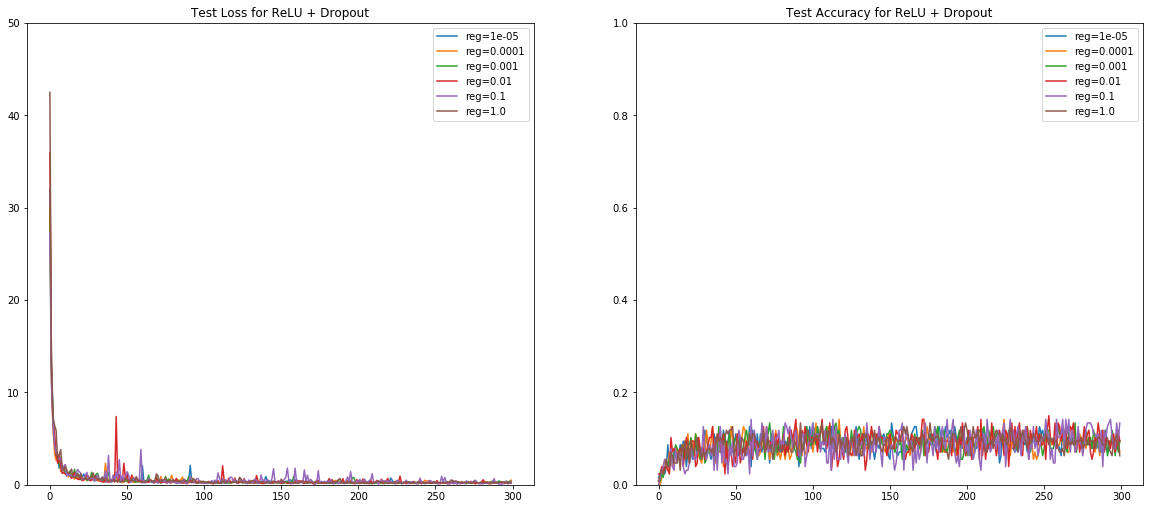

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

legend = []
for lr, loss in list(relu_val_loss.items()):
  ax1.plot(range(0, 300), loss)
  legend.append("reg="+str(lr))

ax1.set_ylim(ymax=50, ymin=0)
ax1.set_title("Test Loss for ReLU + Dropout")
ax1.legend(legend, loc='upper right')

legend = []
for lr, loss in list(relu_val_acc.items()):
  ax2.plot(range(0, 300), loss)
  legend.append("reg="+str(lr))

ax2.set_ylim(ymax=1, ymin=0)
ax2.set_title("Test Accuracy for ReLU + Dropout")
ax2.legend(legend, loc='upper right')

plt.show()

El caso para ReLU no es muy distinto al de Sigmoidal: al igual que con este último, se puede observar que no existen mayores diferencias entre los errores y las exactitudes de los modelos antes y después de la aplicación del Dropout, independiente del valor del parámetro de regularización utilizado, lo que podría ser ocasionado por las razones comentadas anteriormente.

**Parte j)**

En esta sección aplicaremos Validación Cruzada a los modelos b) y c), para determinar la mejor taza de aprendizaje para cada uno. En esta ocasión utilizaremos un número de *folds* igual a $K=5$ y $K=10$ para la determinación de este parámetro.

>1- **Modelo Sigmoidal**, $K=5$

In [62]:
def create_model(learn_rate = 0.01):
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=learn_rate)
  model.compile(optimizer=sgd ,loss='mean_squared_error', metrics=['accuracy'])
  return model
  
Xm = X_train_scaled.as_matrix()
Ym = y_train

learn_rate = np.linspace(0.005, 0.05, 10)
results = []
for lr in learn_rate:
  print("Evaluating lr="+str(lr)+"...")
  kfold = KFold(len(Xm), 5)
  cvscores = []
  for i, (train, val) in enumerate(kfold):
    model = create_model(learn_rate = lr)
    # Fit the model
    model.fit(Xm[train], Ym[train], epochs=200, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xm[val], Ym[val], verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores)
  mse_cv = np.mean(cvscores)
  #std_cv = np.std(cvscores)
  results.append((lr, mse_cv))

results.sort(key=lambda x: x[1], reverse=True)
print("Results (sorted by mean score):")
for lr, score in results:
    print("acc %.2f%% with lr = %.3f" % (score*100, lr))

Evaluating lr=0.005...
Evaluating lr=0.010000000000000002...
Evaluating lr=0.015000000000000003...
Evaluating lr=0.020000000000000004...
Evaluating lr=0.025000000000000005...
Evaluating lr=0.030000000000000006...
Evaluating lr=0.035...
Evaluating lr=0.04...
Evaluating lr=0.045000000000000005...
Evaluating lr=0.05...
Results (sorted by mean score):
acc 204641.82% with lr = 0.020
acc 16.09% with lr = 0.005
acc 13.41% with lr = 0.010
acc 11.72% with lr = 0.015
acc nan% with lr = 0.025
acc nan% with lr = 0.030
acc nan% with lr = 0.035
acc nan% with lr = 0.040
acc nan% with lr = 0.045
acc nan% with lr = 0.050


De las opciones analizadas, podemos observar que la opción que nos brinda el mejor accuracy (16.09%) es un learning rate de 0.005, manteniendo todos los otros hiperparametros de la función constantes entre pruebas. Observamos que para un learning rate de 0.02 se obtiene un accuracy de 204641%, el cual descartamos dado que indica que con dicho lerning rate la red no logrará converger.

>2- **Modelo Sigmoidal**, $K=10$

In [63]:
def create_model(learn_rate = 0.01):
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=learn_rate)
  model.compile(optimizer=sgd ,loss='mean_squared_error', metrics=['accuracy'])
  return model
  
Xm = X_train_scaled.as_matrix()
Ym = y_train

learn_rate = np.linspace(0.005, 0.05, 10)
results = []
for lr in learn_rate:
  print("Evaluating lr="+str(lr)+"...")
  kfold = KFold(len(Xm), 10)
  cvscores = []
  for i, (train, val) in enumerate(kfold):
    model = create_model(learn_rate = lr)
    # Fit the model
    model.fit(Xm[train], Ym[train], epochs=200, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xm[val], Ym[val], verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores)
  mse_cv = np.mean(cvscores)
  #std_cv = np.std(cvscores)
  results.append((lr, mse_cv))

results.sort(key=lambda x: x[1], reverse=True)
print("Results (sorted by mean score):")
for lr, score in results:
    print("acc %.2f%% with lr = %.3f" % (score*100, lr))

Evaluating lr=0.005...
Evaluating lr=0.010000000000000002...
Evaluating lr=0.015000000000000003...
Evaluating lr=0.020000000000000004...
Evaluating lr=0.025000000000000005...
Evaluating lr=0.030000000000000006...
Evaluating lr=0.035...
Evaluating lr=0.04...
Evaluating lr=0.045000000000000005...
Evaluating lr=0.05...
Results (sorted by mean score):
acc 2071.95% with lr = 0.020
acc 16.23% with lr = 0.005
acc 12.21% with lr = 0.010
acc 11.25% with lr = 0.015
acc nan% with lr = 0.025
acc nan% with lr = 0.030
acc nan% with lr = 0.035
acc nan% with lr = 0.040
acc nan% with lr = 0.045
acc nan% with lr = 0.050


Para el caso con $K=10$ observamos los mismos resultados que con $K=5$, es decir, la opción que nos brinda el mejor accuracy (16.23%) es un learning rate de 0.005, manteniendo todos los otros hiperparametros de la función constantes entre pruebas. Dado que en este caso se utilizó *KFold* con un valor de $K$ más alto, podemos concluir que el valor del accuracy para cada modelo fue obtenido de forma más exhaustiva, dándomos una mayor confianza en que el mejor valor de learning rate efectivamente es el más óptimo, a expensas de un tiempo de cálculo considerablemente mayor que para el caso con $K=5$.

>3- **Modelo ReLU**, $K=5$

In [64]:
def create_model(learn_rate = 0.01):
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=learn_rate)
  model.compile(optimizer=sgd ,loss='mean_squared_error', metrics=['accuracy'])
  return model
  
Xm = X_train_scaled.as_matrix()
Ym = y_train

learn_rate = np.linspace(0.005, 0.05, 10)
results = []
for lr in learn_rate:
  print("Evaluating lr="+str(lr)+"...")
  kfold = KFold(len(Xm), 5)
  cvscores = []
  for i, (train, val) in enumerate(kfold):
    model = create_model(learn_rate = lr)
    # Fit the model
    model.fit(Xm[train], Ym[train], epochs=200, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xm[val], Ym[val], verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores)
  mse_cv = np.mean(cvscores)
  #std_cv = np.std(cvscores)
  results.append((lr, mse_cv))

results.sort(key=lambda x: x[1], reverse=True)
print("Results (sorted by mean score):")
for lr, score in results:
    print("acc %.2f%% with lr = %.3f" % (score*100, lr))

Evaluating lr=0.005...
Evaluating lr=0.010000000000000002...
Evaluating lr=0.015000000000000003...
Evaluating lr=0.020000000000000004...
Evaluating lr=0.025000000000000005...
Evaluating lr=0.030000000000000006...
Evaluating lr=0.035...
Evaluating lr=0.04...
Evaluating lr=0.045000000000000005...
Evaluating lr=0.05...
Results (sorted by mean score):
acc 19.69% with lr = 0.015
acc 13.85% with lr = 0.005
acc 12.25% with lr = 0.010
acc nan% with lr = 0.020
acc nan% with lr = 0.025
acc nan% with lr = 0.030
acc nan% with lr = 0.035
acc nan% with lr = 0.040
acc nan% with lr = 0.045
acc nan% with lr = 0.050


Para el caso del modelo ReLU, encontramos que el lerning rate óptimo es ligeramente mayor, en este caso siendo igual a 0.015, pero con la diferencia que este valor de learning rate para el modelo ReLU produce un accuracy de un 19.69%, algo mejor al 16% que presentó el método anterior. En esta línea es importante precisar que, aunque es posible aumentar el número de posibilidades a evaluar para el learning rate, esto conllevrá un aumento en el tiempo de cálculo necesario para analiazr todas las posibiliadades, sobre todo cuando se tiene que $K=10$. Es perfectamente posible aumentar el número de valores del learning rate a evaular y así encontrar un valor que posiblemente entregue un accuracy aún mayor, pero esto requiere de un mayor tiempo de computación que no siempre será factible asumir. Además de lo anterior, es esperable que los valores óptimos del learning rate sean distintos entre ambos modelos, dado el hecho de que cada modelo utiliza una función de activación con características distintas, y requerirán valores del learning rate (y de otros parámetros) personalizados a las características de la red.

>4- **Modelo ReLU**, $K=10$

In [65]:
def create_model(learn_rate = 0.01):
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear'))
  sgd = SGD(lr=learn_rate)
  model.compile(optimizer=sgd ,loss='mean_squared_error', metrics=['accuracy'])
  return model
  
Xm = X_train_scaled.as_matrix()
Ym = y_train

learn_rate = np.linspace(0.005, 0.05, 10)
results = []
for lr in learn_rate:
  print("Evaluating lr="+str(lr)+"...")
  kfold = KFold(len(Xm), 10)
  cvscores = []
  for i, (train, val) in enumerate(kfold):
    model = create_model(learn_rate = lr)
    # Fit the model
    model.fit(Xm[train], Ym[train], epochs=200, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xm[val], Ym[val], verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores)
  mse_cv = np.mean(cvscores)
  #std_cv = np.std(cvscores)
  results.append((lr, mse_cv))

results.sort(key=lambda x: x[1], reverse=True)
print("Results (sorted by mean score):")
for lr, score in results:
    print("acc %.2f%% with lr = %.3f" % (score*100, lr))

Evaluating lr=0.005...
Evaluating lr=0.010000000000000002...
Evaluating lr=0.015000000000000003...
Evaluating lr=0.020000000000000004...
Evaluating lr=0.025000000000000005...
Evaluating lr=0.030000000000000006...
Evaluating lr=0.035...
Evaluating lr=0.04...
Evaluating lr=0.045000000000000005...
Evaluating lr=0.05...
Results (sorted by mean score):
acc 11.03% with lr = 0.005
acc 10.73% with lr = 0.010
acc nan% with lr = 0.015
acc nan% with lr = 0.020
acc nan% with lr = 0.025
acc nan% with lr = 0.030
acc nan% with lr = 0.035
acc nan% with lr = 0.040
acc nan% with lr = 0.045
acc nan% with lr = 0.050


Para el caso con $K=10$ observamos resultados algo distintos a los obtenidos con $K=5$, es decir, la opción que nos brinda el mejor accuracy (11,03%) es un learning rate de 0.005, manteniendo todos los otros hiperparametros de la función constantes entre pruebas. Es interesante notar que la diferencia en el accuracy obtenido por $K=5$ y $K=10$ obtenido para el modelo ReLU es mayor que la diferencia de accuracy's del modelo Sigmoidal. De las misma forma que en el modelo Sigmoidal, dado que en este caso se utilizó *KFold* con un valor de $K$ más alto, podemos concluir que el valor del accuracy para cada modelo fue obtenido de forma más exhaustiva, dándomos una mayor confianza en que el mejor valor de learning rate efectivamente es el más óptimo, a expensas de un tiempo de cálculo considerablemente mayor que para el caso con $K=5$.

<div id='p4' />
## 4. Aplicación de una red neuronal en Localización

En esta pregunta, el objetivo principal es entrenar una red neuronal *feed forward* para la clasificación de las 24 posibles clases definidas en el enunciado de esta pregunta, en base a los datos entregados, con el objetivo de tener un desempeño (*accuracy*) mayor al 75%.

Primero, importamos los datos a un DataFrame

In [66]:
df = pd.read_csv("https://github.com/csaldias/tarea1-RedesNeuronales/raw/master/IndoorFingerprint.csv")
mask_test = np.loadtxt('https://github.com/csaldias/tarea1-RedesNeuronales/raw/master/mask_test.csv',dtype="i")

df.head()

,X,Y,C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI
0,2.0,8.0,-66,-92,-84,-84,-92,-93,-98,-96
1,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-96
2,2.0,8.0,-66,-94,-84,-84,-94,-93,-98,-100
3,2.0,8.0,-66,-94,-84,-84,-94,-80,-98,-100
4,2.0,8.0,-66,-94,-84,-84,-94,-74,-98,-100


Luego, separamos los datos en X e Y, y separamos los datos de validación del resto de los datos

In [0]:
dataset_Y, dataset_X = np.split(df, [2], axis=1)

X_test = dataset_X.iloc[mask_test]
Y_test = dataset_Y.iloc[mask_test]

A continuación, obtenemos los datos de entrenamiento

In [0]:
index_list = np.linspace(0, df.shape[0]-1, num=df.shape[0])
index_train = np.delete(index_list, mask_test, axis=0).astype(int)

X_train = dataset_X.iloc[index_train]
Y_train = dataset_Y.iloc[index_train]

Para poder transformar los datos 2D que son las posiciones del objetivo a un dato 1D como es la zona en la que se encuentra, delimitadas como se especifica en el enunciado, definimos una función auxiliar que, aplicada sobre el Y de validación y de prueba, nos entrega la zona o clase a la que pertenece cada una de las posiciones del dataset.

In [0]:
def get_zone(row):
  if row[0] <= 8:
    if row[1] <= 9:
      return 1
    if row[1] <= 13:
      return 7
    if row[1] <= 17:
      return 13
    if row[1] <= 21:
      return 19
  if row[0] <= 16:
    if row[1] <= 9:
      return 2
    if row[1] <= 13:
      return 8
    if row[1] <= 17:
      return 14
    if row[1] <= 21:
      return 20
  if row[0] <= 24:
    if row[1] <= 9:
      return 3
    if row[1] <= 13:
      return 9
    if row[1] <= 17:
      return 15
    if row[1] <= 21:
      return 21
  if row[0] <= 32:
    if row[1] <= 9:
      return 4
    if row[1] <= 13:
      return 10
    if row[1] <= 17:
      return 16
    if row[1] <= 21:
      return 22
  if row[0] <= 40:
    if row[1] <= 9:
      return 5
    if row[1] <= 13:
      return 11
    if row[1] <= 17:
      return 17
    if row[1] <= 21:
      return 23
  if row[0] <= 48:
    if row[1] <= 9:
      return 6
    if row[1] <= 13:
      return 12
    if row[1] <= 17:
      return 18
    if row[1] <= 21:
      return 24

Y_train_cat = Y_train.apply(lambda x: get_zone(x), axis = 1)
Y_test_cat  = Y_test.apply(lambda x: get_zone(x), axis = 1)

Dado que es una buena práctica, normalizamos los datos de entrenamiento y convertimos los Y de prueba y validación a vectores *onehot*

In [0]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
scaler = StandardScaler().fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

from keras.utils import to_categorical
Y_train_onehot = to_categorical(Y_train_cat)
Y_test_onehot = to_categorical(Y_test_cat)

La red utilizada para este problema es una red *feed-forward* con 200 neuronas en la primera cada y 100 neuronas en la segunda, utilizando en ambas una función de activación ReLU. Como optimizador hemos escogido utilizar Adam con un *learning rate* de 0.005, utilizando *Mean Squared Error* para el cálculo del error, y entrenando por 200 epochs.

In [71]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(100, kernel_initializer='uniform', activation='relu'))
model.add(Dense(25, kernel_initializer='uniform', activation='linear'))
model.compile(optimizer=Adam(lr=0.005), loss='mse', metrics=['accuracy'])
hist = model.fit(X_train_scaled.as_matrix(), Y_train_onehot, epochs=200, verbose=1, validation_data=(X_test_scaled.as_matrix(), Y_test_onehot))

Train on 4620 samples, validate on 1980 samples
Epoch 1/200
4620/4620 [==============================] - 19s 4ms/step - loss: 0.0236 - acc: 0.6420 - val_loss: 0.0165 - val_acc: 0.8061
Epoch 2/200
4620/4620 [==============================] - 2s 331us/step - loss: 0.0138 - acc: 0.8437 - val_loss: 0.0118 - val_acc: 0.8753
Epoch 3/200
4620/4620 [==============================] - 1s 290us/step - loss: 0.0097 - acc: 0.9004 - val_loss: 0.0102 - val_acc: 0.8838
Epoch 4/200
4620/4620 [==============================] - 1s 301us/step - loss: 0.0079 - acc: 0.9199 - val_loss: 0.0084 - val_acc: 0.9212
Epoch 5/200
4620/4620 [==============================] - 1s 300us/step - loss: 0.0069 - acc: 0.9370 - val_loss: 0.0076 - val_acc: 0.9242
Epoch 6/200
4620/4620 [==============================] - 1s 299us/step - loss: 0.0068 - acc: 0.9420 - val_loss: 0.0077 - val_acc: 0.9333
Epoch 7/200
4620/4620 [==============================] - 1s 301us/step - loss: 0.0059 - acc: 0.9498 - val_loss: 0.0070 - val_acc: 0

 544/4620 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.99824620/4620 [==============================] - 1s 290us/step - loss: 0.0017 - acc: 0.9924 - val_loss: 0.0036 - val_acc: 0.9677
Epoch 62/200
4620/4620 [==============================] - 1s 288us/step - loss: 0.0016 - acc: 0.9929 - val_loss: 0.0036 - val_acc: 0.9636
Epoch 63/200
4620/4620 [==============================] - 1s 288us/step - loss: 0.0015 - acc: 0.9926 - val_loss: 0.0029 - val_acc: 0.9742
Epoch 64/200
4620/4620 [==============================] - 2s 341us/step - loss: 0.0015 - acc: 0.9924 - val_loss: 0.0032 - val_acc: 0.9682
Epoch 65/200
4620/4620 [==============================] - 1s 314us/step - loss: 0.0016 - acc: 0.9924 - val_loss: 0.0033 - val_acc: 0.9692
Epoch 66/200
4620/4620 [==============================] - 1s 292us/step - loss: 0.0015 - acc: 0.9922 - val_loss: 0.0033 - val_acc: 0.9631
Epoch 67/200
4620/4620 [==============================] - 1s 292us/step - loss: 0.0015 - acc: 0.9918 - v

Epoch 117/200
4620/4620 [==============================] - 1s 288us/step - loss: 0.0012 - acc: 0.9946 - val_loss: 0.0032 - val_acc: 0.9652
Epoch 118/200
4620/4620 [==============================] - 1s 284us/step - loss: 0.0011 - acc: 0.9948 - val_loss: 0.0031 - val_acc: 0.9712
Epoch 119/200
4620/4620 [==============================] - 1s 282us/step - loss: 0.0012 - acc: 0.9926 - val_loss: 0.0032 - val_acc: 0.9697
Epoch 120/200
4620/4620 [==============================] - 1s 287us/step - loss: 0.0013 - acc: 0.9933 - val_loss: 0.0033 - val_acc: 0.9682
Epoch 121/200
4620/4620 [==============================] - 1s 285us/step - loss: 0.0012 - acc: 0.9955 - val_loss: 0.0030 - val_acc: 0.9697
Epoch 122/200
4620/4620 [==============================] - 1s 289us/step - loss: 0.0012 - acc: 0.9933 - val_loss: 0.0031 - val_acc: 0.9712
Epoch 123/200
4620/4620 [==============================] - 1s 287us/step - loss: 0.0011 - acc: 0.9942 - val_loss: 0.0031 - val_acc: 0.9707
Epoch 124/200
4620/4620 [==

 256/4620 [>.............................] - ETA: 1s - loss: 0.0012 - acc: 1.0000    4620/4620 [==============================] - 1s 297us/step - loss: 0.0014 - acc: 0.9924 - val_loss: 0.0036 - val_acc: 0.9626
Epoch 179/200
4620/4620 [==============================] - 1s 295us/step - loss: 0.0013 - acc: 0.9922 - val_loss: 0.0032 - val_acc: 0.9662
Epoch 180/200
4620/4620 [==============================] - 1s 288us/step - loss: 0.0013 - acc: 0.9924 - val_loss: 0.0035 - val_acc: 0.9571
Epoch 181/200
4620/4620 [==============================] - 1s 288us/step - loss: 0.0013 - acc: 0.9920 - val_loss: 0.0035 - val_acc: 0.9657
Epoch 182/200
4620/4620 [==============================] - 1s 298us/step - loss: 0.0014 - acc: 0.9924 - val_loss: 0.0039 - val_acc: 0.9566
Epoch 183/200
4620/4620 [==============================] - 1s 296us/step - loss: 0.0014 - acc: 0.9920 - val_loss: 0.0038 - val_acc: 0.9631
Epoch 184/200
4620/4620 [==============================] - 1s 297us/step - loss: 0.0014 - acc: 

Ahora, obtenemos gráficos de la evolución de los errores y accuracy de entrenamiento y validación:

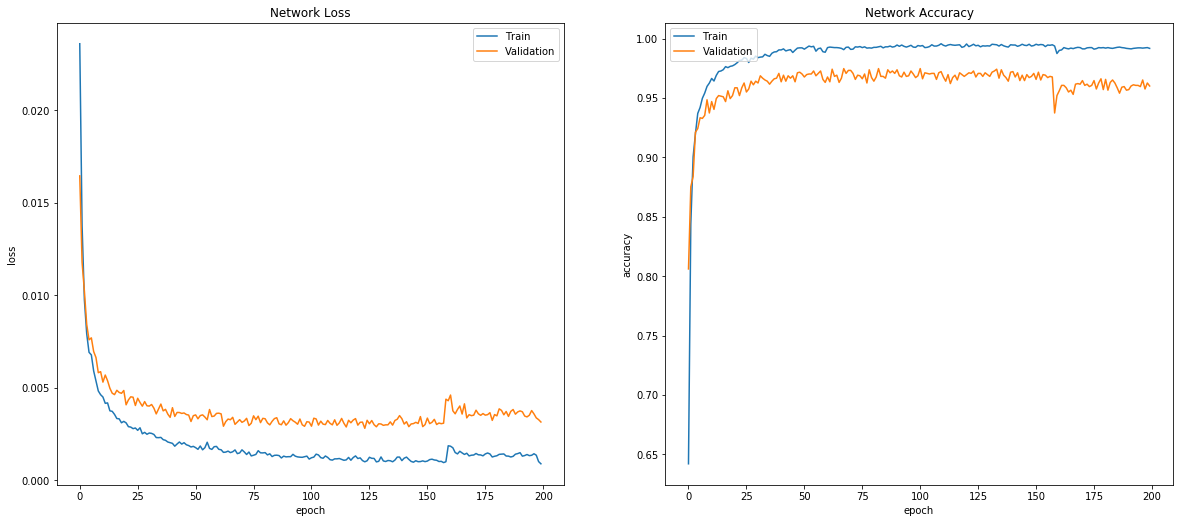

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))
ax1.plot(range(0, 200), hist.history['loss'])
ax1.plot(range(0, 200), hist.history['val_loss'])

#ax1.set_ylim(ymax=ymax, ymin=0)
ax1.set_title("Network Loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend(["Train", "Validation"], loc='upper right')

ax2.plot(range(0, 200), hist.history['acc'])
ax2.plot(range(0, 200), hist.history['val_acc'])

#ax2.set_ylim(ymax=ymax, ymin=0)
ax2.set_title("Network Accuracy")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend(["Train", "Validation"], loc='upper left')

plt.show()

Como podemos obervar de los gráficos de error y accuracy de nuestra red, podemos observar que la red se desempeño excepcionalmente bien modelando las características de nuestro dataset, logrando un accuracy de más del 95% luego de 200 epochs, bien por sobre el 75% requerido por el enunciado de esta pregunta. Esto se dio principalmente por la elección de optimizador que utilizamos (en este caso, Adam con learning rate de 0.05), la estructura de las capas internas (2 capas internas con 200 y 100 neuronas, cada una) y también a la calidad del dataset utilizado para el entrenamiento.

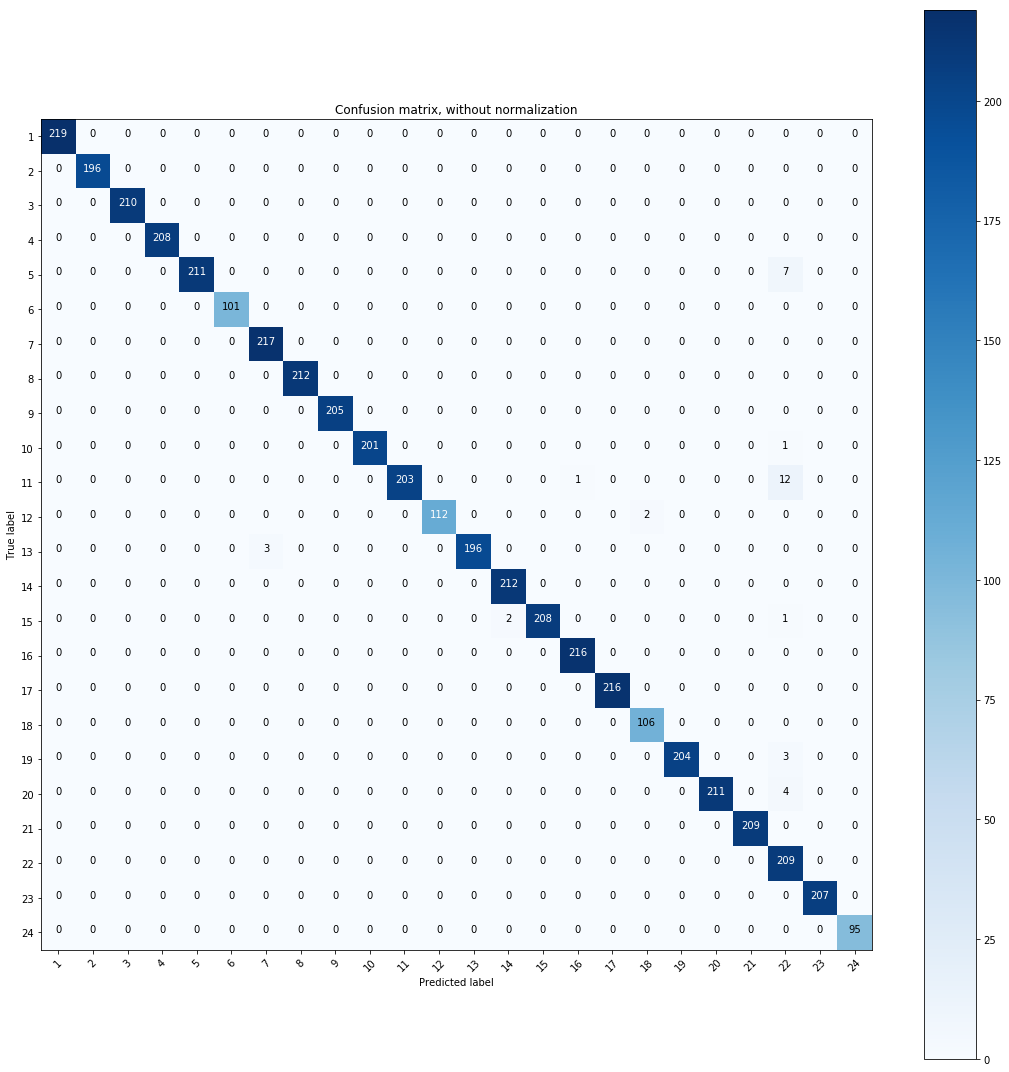

In [73]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_predicted = model.predict(X_train_scaled.as_matrix())
cnf_matrix = confusion_matrix(np.argmax(Y_train_onehot, axis=1), np.argmax(Y_predicted, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = np.linspace(1,24,24).astype(int)
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Como última comprobación del desempeño del modelo, obtenemos la matriz de confusión del mismo, de la cual se observan que son muy pocos los casos en los que el modelo realiza una predicción errónea frente a los datos de entrenamiento, reafirmando una vez más el buen desempeño de la misma.